# Pseudo-bulk tutorial

This Jupyter Notebook shows how to analyse pseudo-bulk scRNA-seq and scATAC-seq data with MUSIC.

In [1]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
import os
import numpy as np
import pandas as pd

import pyro

import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer.autoguide.guides import AutoNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, Predictive

import itertools

from sklearn.preprocessing import StandardScaler

import torch

from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f13e6653fa0>


In [5]:
from parafac import models, synthetic, plots

In [6]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-torch.nan_to_num(y))**2))

## Pre processing

The data consists of two scRNA and scATAC dataset that have already been pre-filtered on the cells and genes basis, and the UMI and peak values were aggregated on the sample x cell type basis, giving us two dataframes of samples/cell-type and features. Metadata was also provided by the authors

In [7]:
# Import data
scRNA = pd.read_csv("/home/kdeazevedo/Codes/github/scRNAseq_granular_correctedVarFeat.tsv", sep = "\t", index_col = None)
scATAC = pd.read_csv("/home/kdeazevedo/Codes/github/scATACseq_granular_correctedVarFeat.tsv", sep = "\t", index_col = None)
metadata_scRNA = pd.read_csv("/home/kdeazevedo/metadata_scRNA_patient.tsv", sep = "\t", index_col = 0)
metadata_scRNA_normcell = pd.read_csv("/home/kdeazevedo/metadata_scATAC_patient_normcell.tsv", sep = "\t", index_col = 0)
metadata_scATAC = pd.read_csv("/home/kdeazevedo/metadata_scATAC_patient.tsv", sep = "\t", index_col = 0)
metadata_scATAC_normcell = pd.read_csv("/home/kdeazevedo/metadata_scATAC_patient_normcell.tsv", sep = "\t", index_col = 0)
metadata_scRNA_merged = pd.read_csv("/home/kdeazevedo/metadata_RNA_merge.tsv", sep = "\t", index_col = 0)
metadata_scATAC_merged = pd.read_csv("/home/kdeazevedo/metadata_ATAC_merge.tsv", sep = "\t", index_col = 0)

/tmp/ipykernel_1028243/2864951291.py:8: DtypeWarning: Columns (3,4,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_scRNA_merged = pd.read_csv("/home/kdeazevedo/metadata_RNA_merge.tsv", sep = "\t", index_col = 0)


In [11]:
scRNA=scRNA.drop(columns=['perc.mito', 'nCount_RNA', 'nFeature_RNA',
                          'detected_nfusion', 'pseudotime', 'detected_nwt',
                          'HeatShock.Score1', 'S.Score', 'G2M.Score'])
df_strings = scRNA[['Ctype', 'sample']]  # Selecting the string column
df_numeric = scRNA.drop(['Ctype', 'sample'], axis=1)  # Dropping the string column for scaling
# Apply StandardScaler to numeric columns
scaler = StandardScaler()
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
# Concatenate the scaled numeric columns back with the string column
scRNA = pd.concat([df_strings, df_scaled_numeric], axis=1)

,Ctype,sample,S100A8,S100A9,MT1G,MT1H,C1QB,S100A12,IGKC,LYZ,...,AL355512.1,SLC2A4,AC008568.1,AC005392.2,SCARA3,FGF20,LINC00923,AC015922.4,AC123912.4,SNAP25
0,Blasts,1154,-0.504797,-0.560135,-0.031572,-0.150069,-0.186287,-0.376073,-0.098013,-0.577810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mature_B,1154,-0.505847,-0.561676,-0.197665,-0.150069,-0.186287,-0.376073,1.591522,-0.621063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monocytes,1154,-0.055599,0.606027,-0.197665,-0.150069,4.150392,-0.376073,-0.673381,0.869951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Progenitors,1154,-0.505847,-0.561676,-0.197665,-0.150069,-0.186287,-0.376073,-0.690763,-0.467910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T/NK,1154,-0.504205,-0.556684,-0.136896,-0.150069,-0.186287,-0.376073,-0.720608,-0.618475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Mature_B,donor2689,1.412611,0.694029,-0.197665,NaN,-0.175265,0.167454,1.628488,0.652289,...,-0.053519,-0.256871,-0.236093,-0.319143,0.0,-0.229836,-0.207153,-0.222746,-0.185695,-0.243317
118,Monocytes,donor2689,3.648470,2.723509,-0.041573,NaN,-0.138450,3.867840,-0.574977,2.909733,...,-0.207825,-0.256871,-0.236093,0.865848,0.0,-0.229836,-0.207153,-0.222746,-0.185695,-0.243317
119,Progenitors,donor2689,-0.344082,-0.419886,-0.168729,NaN,-0.186287,-0.316100,-0.780364,-0.178116,...,-0.339868,2.526759,0.178394,-0.319143,0.0,1.241137,-0.207153,-0.222746,-0.185695,1.804126
120,T/NK,donor2689,1.408138,0.713962,-0.197665,NaN,-0.164468,0.230997,-0.479669,0.693090,...,-0.339868,-0.256871,-0.236093,-0.319143,0.0,-0.229836,-0.207153,-0.222746,-0.185695,-0.243317


In [13]:
scATAC=scATAC.drop(columns=['nCount_ATAC', 'nFeature_ATAC',
                           'pseudotime', 'S.Score', 'G2M.Score'])
df_strings = scATAC[['Ctype', 'sample']]  # Selecting the string column
df_numeric = scATAC.drop(['Ctype', 'sample'], axis=1)  # Dropping the string column for scaling
# SApply StandardScaler to numeric columns
scaler = StandardScaler()
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
# Concatenate the scaled numeric columns back with the string column
scATAC = pd.concat([df_strings, df_scaled_numeric], axis=1)

,Ctype,sample,"chrM-11746-16534,MT-ND4-Tss,MT-ND5-Tss,MT-ND6-Tss,MT-CYB-Tss","chrM-8-3949,MT-ND1-Tss,MT-ND2-Tss","chrM-10418-11542,MT-ND3-Tss,MT-ND4L-Tss,MT-ND4-Tss,MT-ND5-Tss","chrM-6150-6700,MT-CO1-Tss,MT-CO2-Tss","chrM-7758-8258,MT-CO2-Tss,MT-ATP8-Tss,MT-ATP6-Tss,MT-CO3-Tss","chrM-4672-5172,MT-ND2-Tss,MT-CO1-Tss","chr19-54189087-54191805,MBOAT7-Tss,TSEN34-Tss","chr15-75450297-75455039,SIN3A-Tss",...,"chr22-31489033-31490909,EIF4ENIF1-Tss","chr9-129035994-129037403,FAM73B-Tss","chr8-70607407-70608751,TRAM1-Tss,RP11-382J12.1-Tss","chr14-56117733-56119800,CTD-2588E21.1-Tss,PELI2-Tss","chr10-63268800-63269521,JMJD1C-Tss","chr2-70257334-70258826,PCYOX1-Tss","chr7-142853811-142855731,EPHB6-Tss","chr12-45726757-45728016,RP11-352M15.2-Tss",nCount_RNA,nFeature_RNA
0,Blasts,1154,0.205016,0.161508,-0.011414,-0.069464,-0.098980,-0.072501,-0.960262,-1.399125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mature_B,1154,1.012565,0.991279,0.910405,0.854811,0.809501,1.118565,-1.361201,-1.756306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monocytes,1154,-0.080884,-0.161773,-0.381739,-0.341967,-0.415702,-0.360371,-1.247665,-1.525580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Progenitors,1154,0.430861,0.387664,0.207619,0.135142,0.097247,0.087002,-1.189516,-1.280427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T/NK,1154,0.024671,-0.047127,-0.180316,-0.251991,-0.253097,-0.260760,-1.209446,-1.481188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Progenitors,PAZGKI,-0.302481,-0.263639,-0.541497,-0.615117,-0.611488,-0.543373,-0.858280,-0.644833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,T/NK,PAZGKI,-1.025208,-1.012017,-1.066310,-1.004763,-0.981461,-0.947482,0.227079,0.365075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,Monocytes,donor2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.190729,-0.183030,1.876922,2.220677,-0.621273,2.347370,1.571442,1.331666,0.014534,-0.154724
104,Monocytes,donor2689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.181785,0.458010,-0.575730,-0.554491,-0.429830,-0.536685,1.882190,1.986650,-0.820988,-0.715777


In [16]:
scRNA['Condition'] = np.where(scRNA['sample'].isin(['HumanHealthy_2117', 'HumanHealthy_2471', 'donor2111', 'donor2153', 'donor2689']), 
                           'Healthy', 'ALL')

In [17]:
metadata_scRNA_merged['Condition'] = np.where(metadata_scRNA_merged['sample'].isin(['HumanHealthy_2117', 'HumanHealthy_2471', 'donor2111', 'donor2153', 'donor2689']), 
                           'Healthy', 'ALL')

In [18]:
# Step 1: Get all unique combinations of 'Sample' and 'Cell_Type' from df1
combinations = scRNA.reset_index()[['sample', 'Ctype']].drop_duplicates()

# Step 2: Merge with df2 on 'Sample' and 'Cell_Type', filling missing rows with NaN
df_merged = pd.merge(combinations, scATAC, on=['sample', 'Ctype'], how='left')

In [20]:
scRNA = scRNA.set_index('sample')
scATAC = scATAC.set_index('sample')

We observe the data with PCA

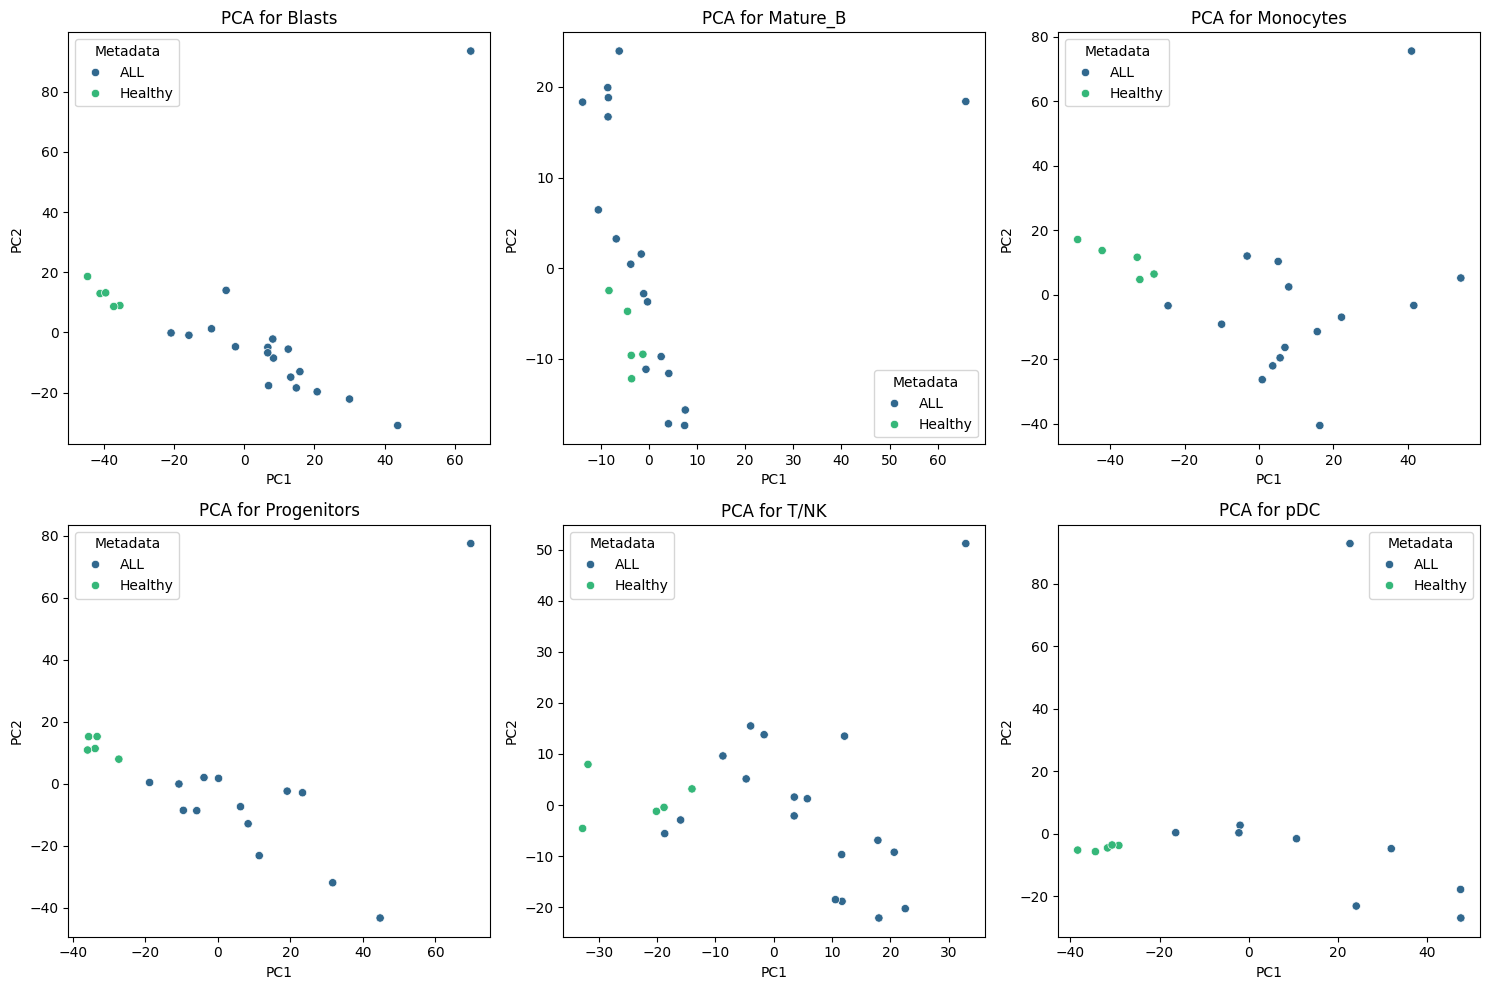

In [21]:
cell_types = scRNA['Ctype'].unique()  # List of cell types you want to subset
n_per_panel = 6  # Number of PCA plots per panel

# List to store the PCA results DataFrame for each cell type
pca_plots = []

# Iterate through the cell types and perform PCA for each subset
for cell_type in cell_types:
    # Subset the dataframe for the current cell type
    df_subset = scRNA[scRNA['Ctype'] == cell_type]
    df_subset = df_subset.fillna(0)
    
    # Assuming the rest of the columns are the numeric data for PCA
    pca_data = df_subset.drop(columns=['Ctype', 'Condition'])
    
    # Perform PCA 
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(pca_data)
    
    # Create a DataFrame for the PCA result
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(3)])
    pca_df['Ctype'] = cell_type  # Add the cell type for labeling
    pca_df['Metadata'] = df_subset.Condition.values
    
    # Store the PCA DataFrame in the list for later use
    pca_plots.append(pca_df)

# Now create panels of PCA plots in sets of 'n_per_panel' (e.g., 6 per panel)
n_panels = len(cell_types) // n_per_panel + (len(cell_types) % n_per_panel > 0)
for panel in range(n_panels):
    # Create subplots for the current panel
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Example: 2 rows, 3 columns
    axes = axes.flatten()
    
    # For each PCA DataFrame, plot on the corresponding axis
    for i in range(n_per_panel):
        idx = panel * n_per_panel + i
        if idx >= len(pca_plots):
            axes[i].axis('off')  # Hide any unused subplot axes
            continue  # Exit if there are no more cell types to plot
        
        # Plot the PCA result for the current cell type on the panel
        sns.scatterplot(x='PC1', y='PC2', hue='Metadata', data=pca_plots[idx], ax=axes[i], palette='viridis')
        axes[i].set_title(f'PCA for {cell_types[idx]}')
    
    # Adjust layout and show the panel
    plt.tight_layout()
    plt.show()

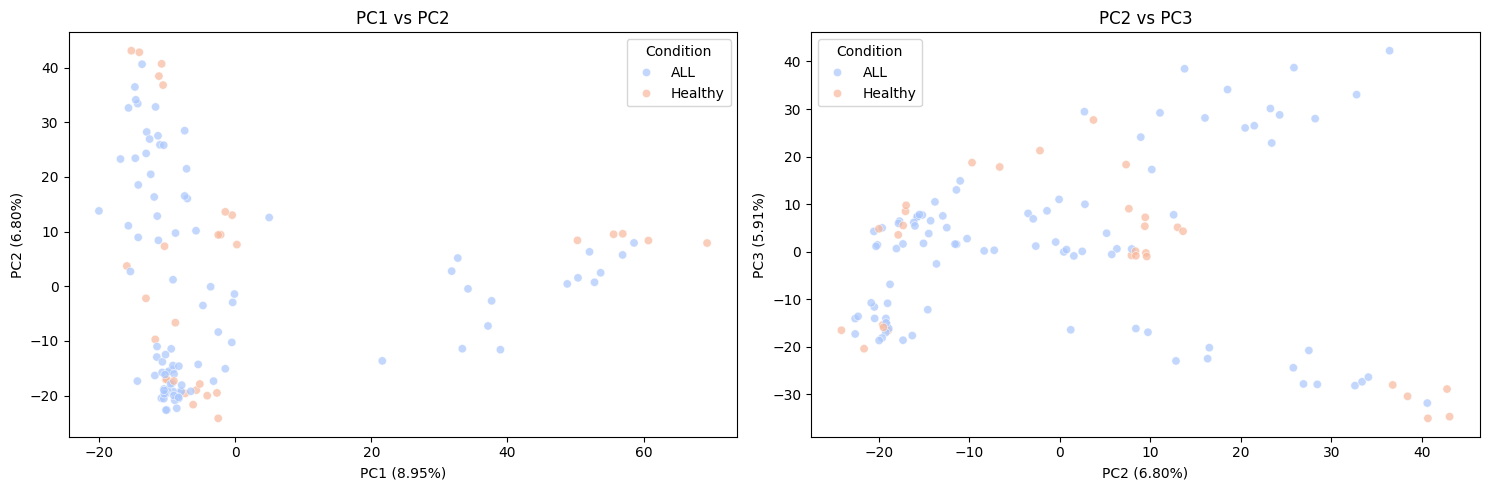

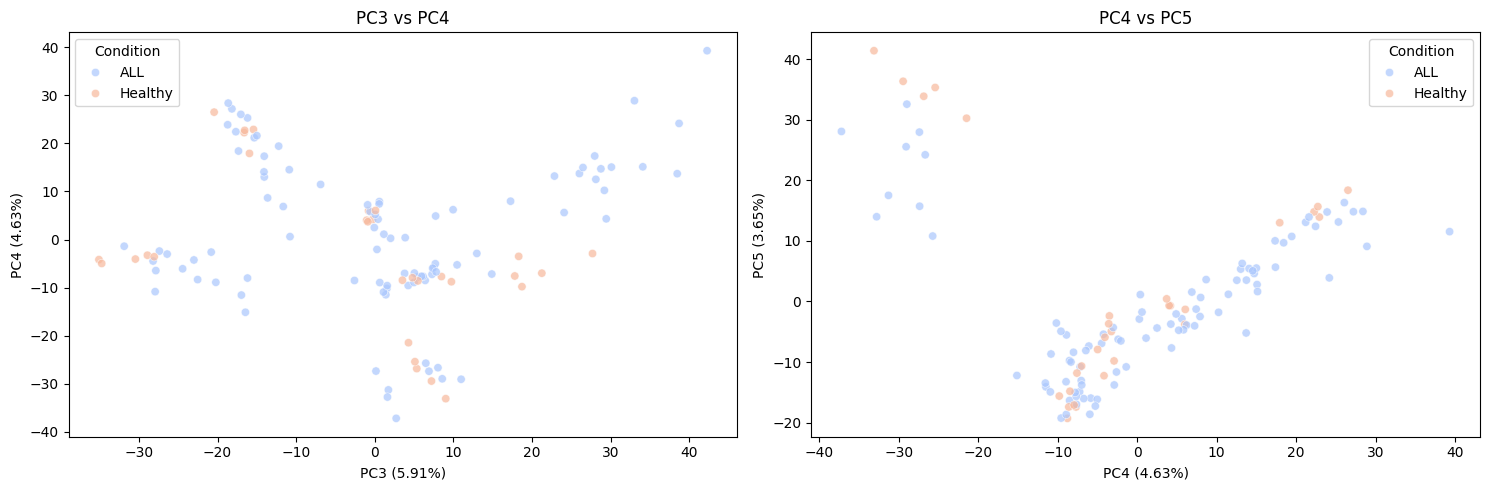

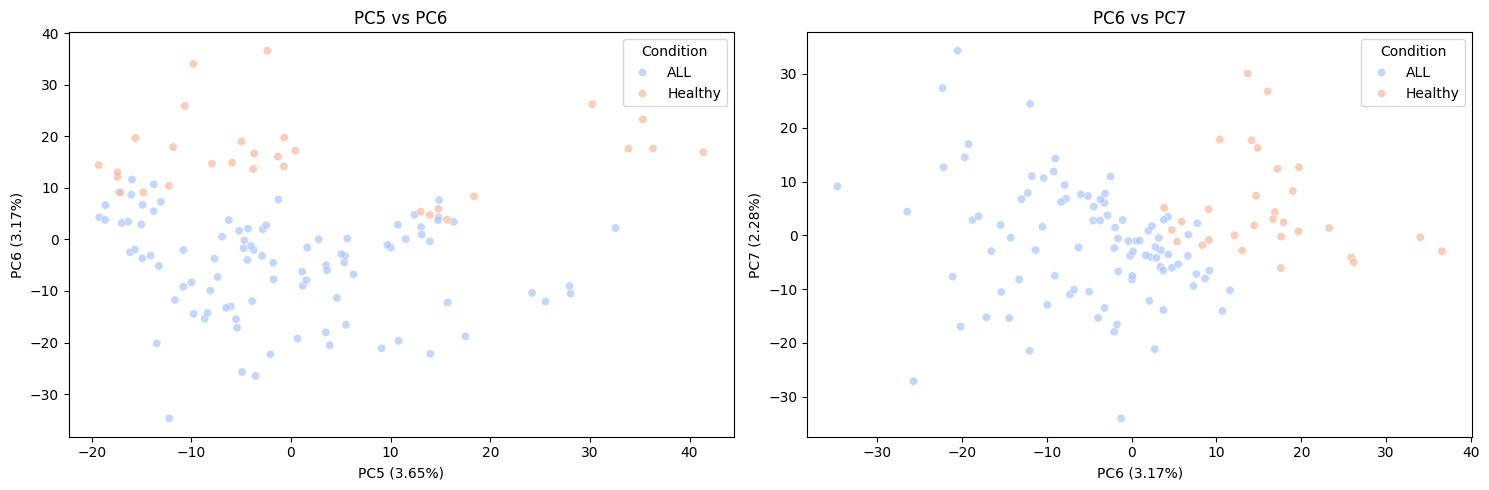

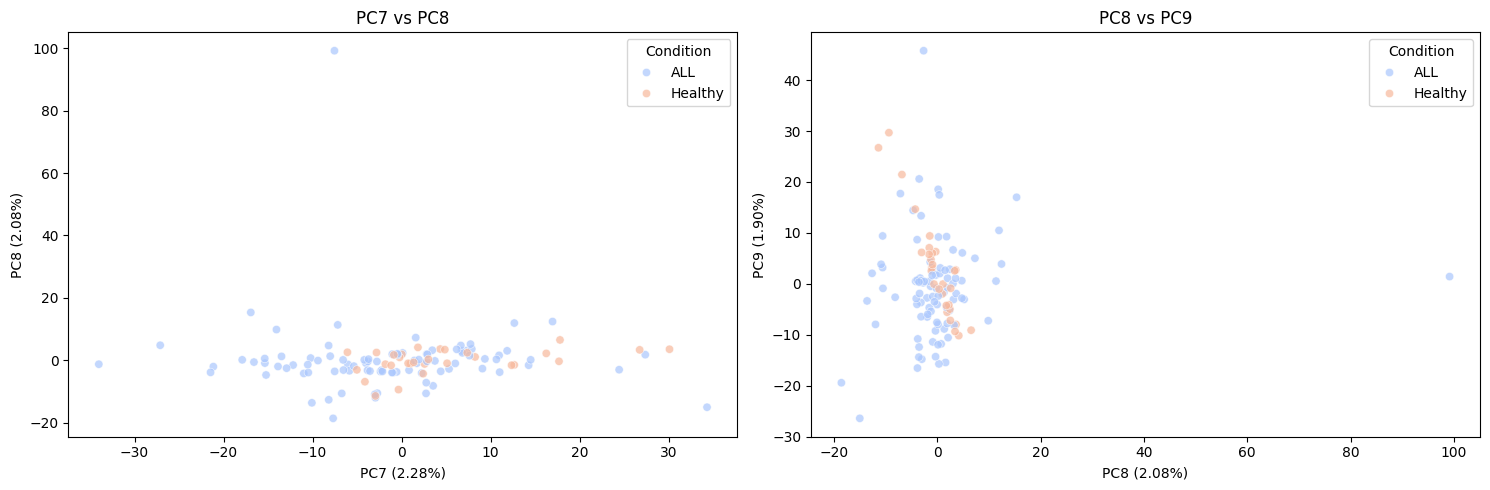

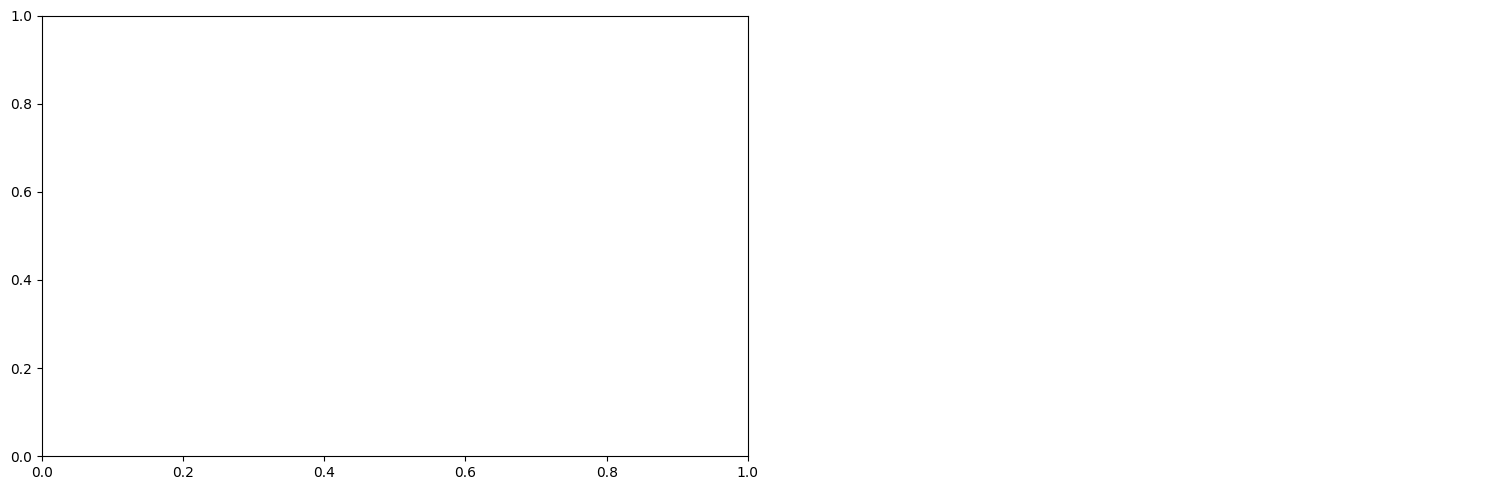

In [22]:
df = scRNA
df.fillna(0, inplace=True)

# Perform PCA on the entire dataset (excluding non-numeric columns)
pca_data = df.drop(columns=['Ctype', 'Condition'])  # Drop non-numeric columns

# Perform PCA
pca = PCA(n_components=9)
pca_result = pca.fit_transform(pca_data)

# Create a DataFrame for the PCA result
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(9)])
pca_df['Ctype'] = df['Ctype'].values  # Add CellType for coloring
pca_df['Condition'] = df['Condition'].values  # Add Condition for coloring

# Set up the number of PCs to use for panels
n_pcs = 9  # Total number of PCs
n_per_panel = 2  # Number of PCs per panel

# Calculate the number of panels needed
n_panels = n_pcs // n_per_panel + (n_pcs % n_per_panel > 0)

explained_variance = pca.explained_variance_ratio_ * 100

# Create panels of PCA plots for successive combinations of PCs
for panel in range(n_panels):
    # Create subplots for the current panel
    fig, axes = plt.subplots(1, n_per_panel, figsize=(15, 5))
    axes = axes.flatten()
    
    for i in range(n_per_panel):
        idx = panel * n_per_panel + i
        if idx >= n_pcs:
            axes[i].axis('off')  # Hide unused subplots
            continue
        
        # Plot the PCA result for the current pair of PCs
        pc_x = f'PC{idx+1}'
        pc_y = f'PC{idx+2}' if idx + 1 < n_pcs else None
        
        if pc_y:  # Check if the second PC exists
            sns.scatterplot(x=pc_x, y=pc_y, hue='Condition', data=pca_df, ax=axes[i], palette='coolwarm', alpha=0.7)
            axes[i].set_title(f'{pc_x} vs {pc_y}')

            axes[i].set_xlabel(f'{pc_x} ({explained_variance[idx]:.2f}%)')
            axes[i].set_ylabel(f'{pc_y} ({explained_variance[idx + 1]:.2f}%)')
    

    
    plt.tight_layout()
    plt.show()

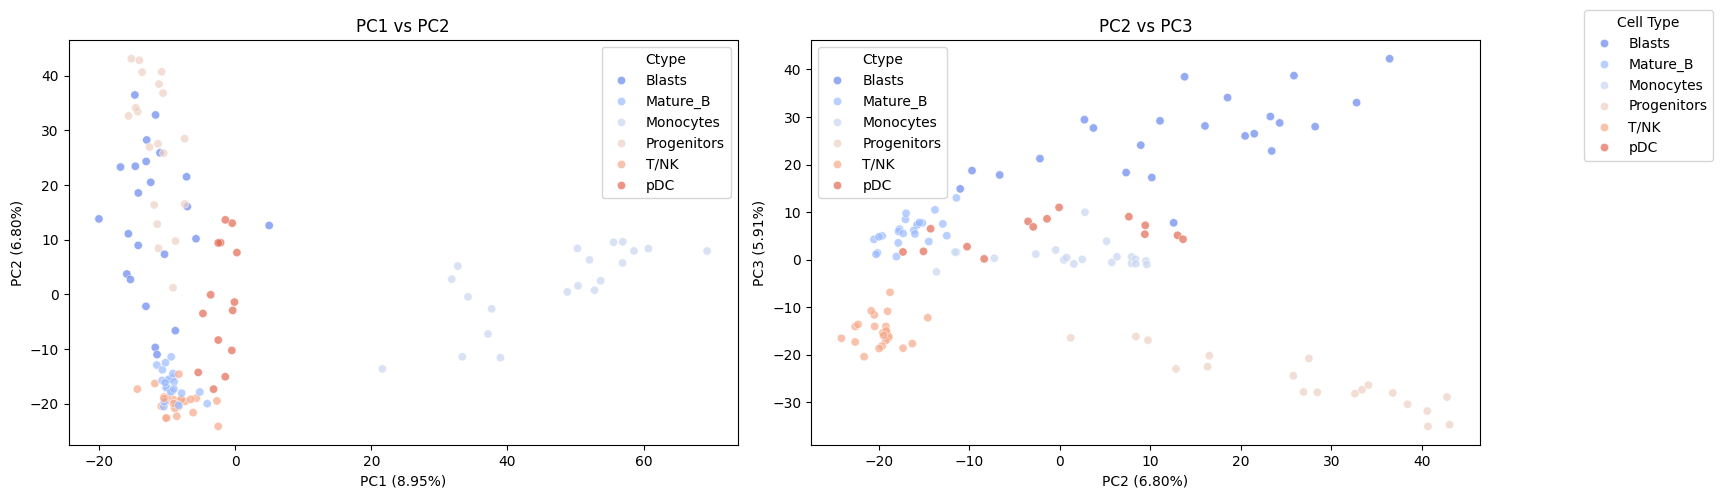

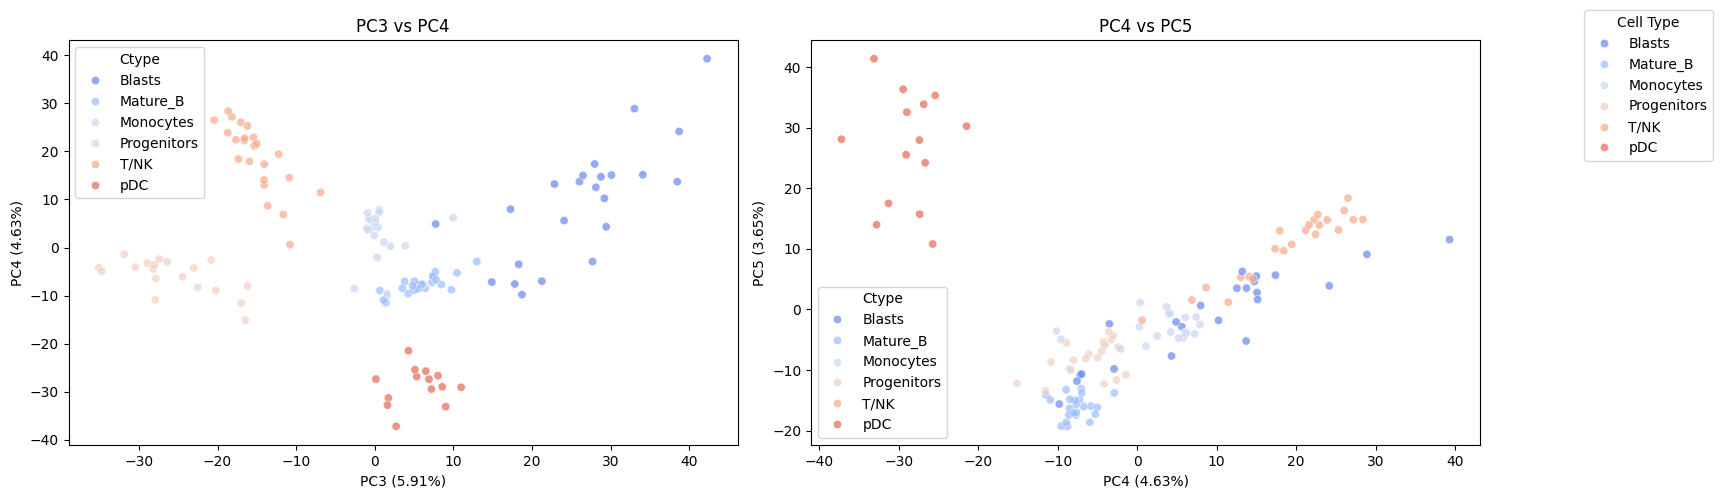

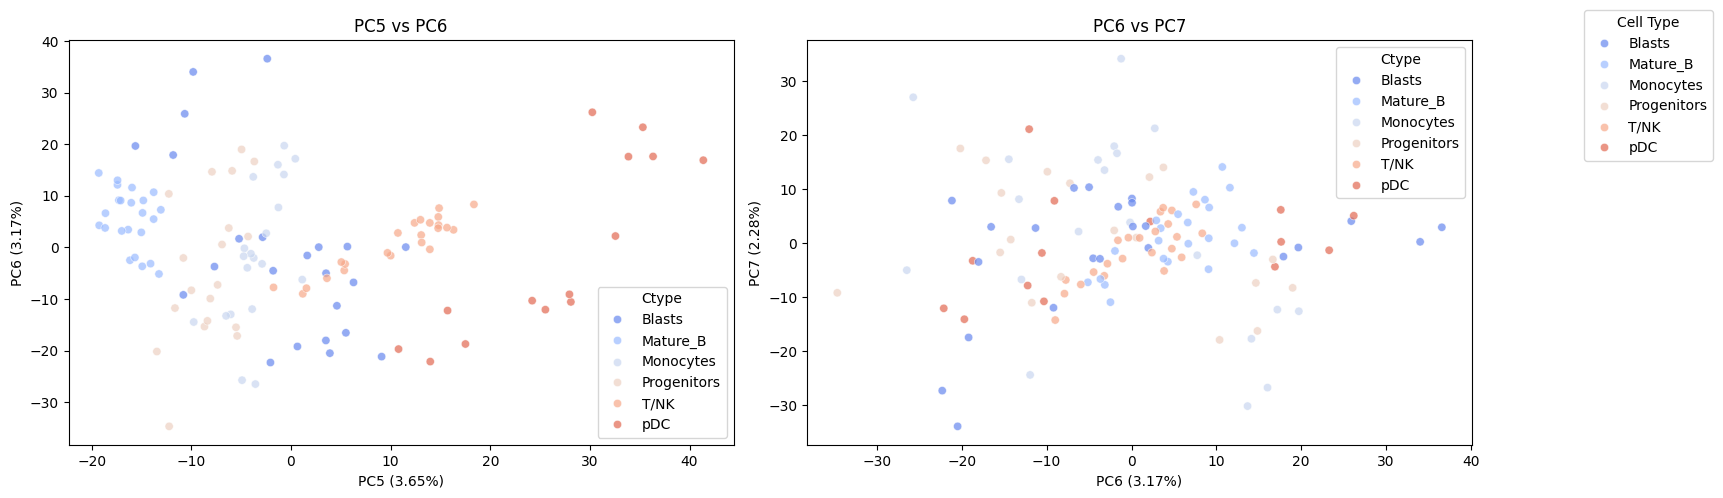

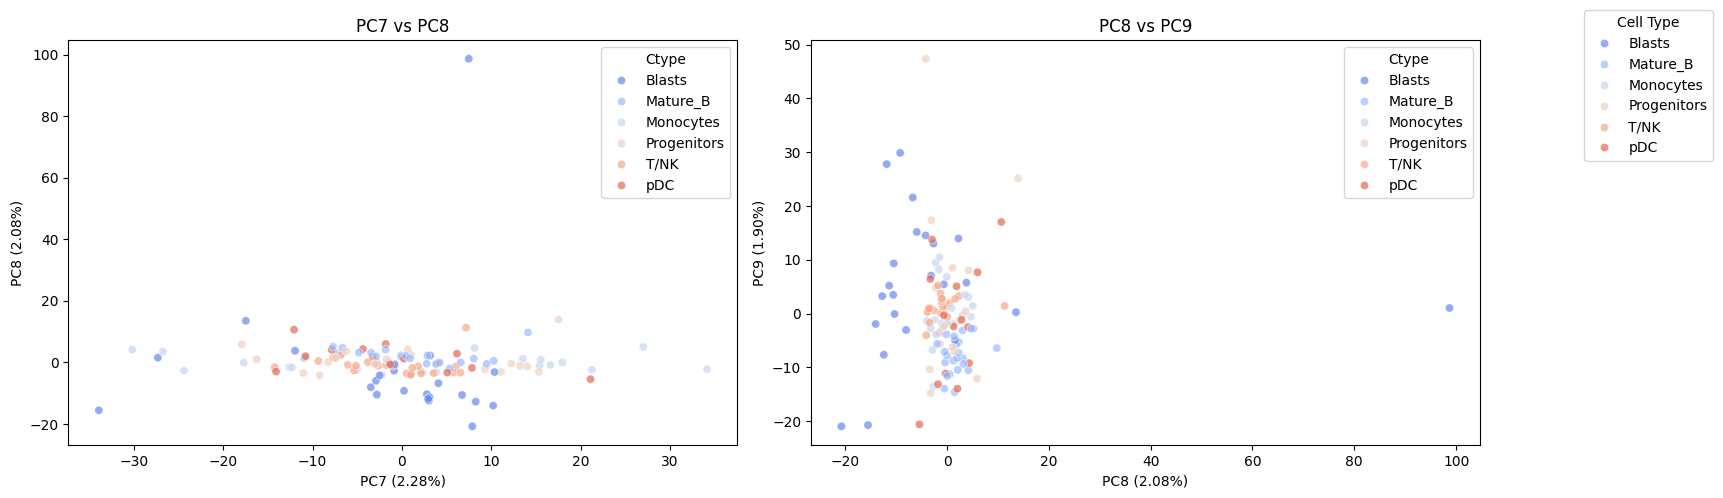

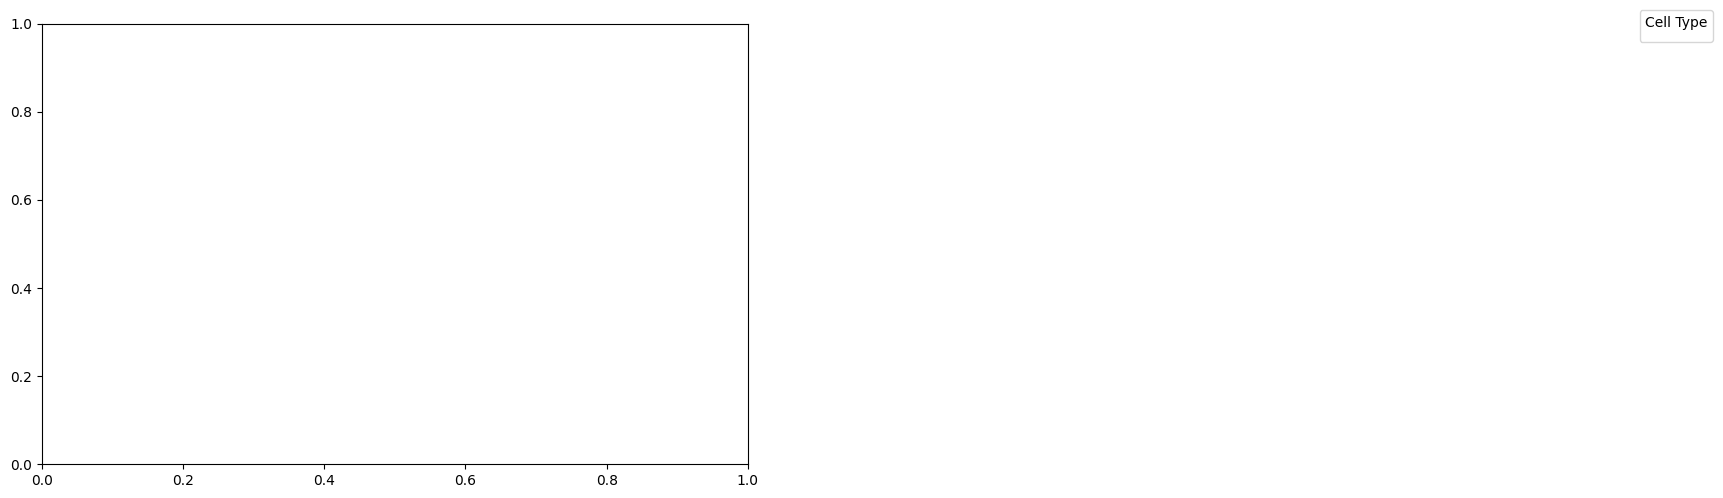

In [23]:
df = scRNA
df.fillna(0, inplace=True)

# Perform PCA on the entire dataset (excluding non-numeric columns)
pca_data = df.drop(columns=['Ctype', 'Condition'])  # Drop non-numeric columns

# Perform PCA
pca = PCA(n_components=9)
pca_result = pca.fit_transform(pca_data)

# Create a DataFrame for the PCA result
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(9)])
pca_df['Ctype'] = df['Ctype'].values  # Add CellType for coloring
pca_df['Condition'] = df['Condition'].values  # Add Condition for coloring

# Set up the number of PCs to use for panels
n_pcs = 9  # Total number of PCs
n_per_panel = 2  # Number of PCs per panel

# Calculate the number of panels needed
n_panels = n_pcs // n_per_panel + (n_pcs % n_per_panel > 0)

explained_variance = pca.explained_variance_ratio_ * 100

# Create panels of PCA plots for successive combinations of PCs
for panel in range(n_panels):
    # Create subplots for the current panel
    fig, axes = plt.subplots(1, n_per_panel, figsize=(15, 5))
    axes = axes.flatten()
    
    for i in range(n_per_panel):
        idx = panel * n_per_panel + i
        if idx >= n_pcs:
            axes[i].axis('off')  # Hide unused subplots
            continue
        
        # Plot the PCA result for the current pair of PCs
        pc_x = f'PC{idx+1}'
        pc_y = f'PC{idx+2}' if idx + 1 < n_pcs else None
        
        if pc_y:  # Check if the second PC exists
            scatter = sns.scatterplot(x=pc_x, y=pc_y, hue='Ctype', data=pca_df, ax=axes[i], palette='coolwarm', alpha=0.7)
            axes[i].set_title(f'{pc_x} vs {pc_y}')

            axes[i].set_xlabel(f'{pc_x} ({explained_variance[idx]:.2f}%)')
            axes[i].set_ylabel(f'{pc_y} ({explained_variance[idx + 1]:.2f}%)')


    handles, labels = axes[0].get_legend_handles_labels()  # Use the first axis to get handles and labels
    unique_labels = dict(zip(labels, handles))  # Ensure uniqueness
    fig.legend(unique_labels.values(), unique_labels.keys(), title='Cell Type', loc='upper right', bbox_to_anchor=(1.15, 1))
    

    # Create a single legend for the entire panel
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()

### Tensor creation

We create the two tensors of size samples x cell type x feature for both dataset

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Step 1: One-hot encode the cell types
encoder = OneHotEncoder(sparse_output=False)
cell_types_encoded = encoder.fit_transform(scRNA[['Ctype']])  # Convert to a dense array

# Step 2: Extract the gene values
df=scRNA
df=df.drop(columns=['Condition'])
genes = df.iloc[:, 1:].values  # All gene columns


# Step 3: Determine the shape of the tensor
unique_samples = df.index.unique()  # Get the unique samples from the index
sample_mapping = {sample: i for i, sample in enumerate(unique_samples)}  # Map samples to indices

samples = len(unique_samples)  # Number of unique samples
cell_type_dim = cell_types_encoded.shape[1]  # Number of unique cell types (after one-hot encoding)
genes_dim = genes.shape[1]  # Number of genes

# Step 4: Initialize a 3D tensor of zeros (samples x cell types x genes)
tensor_3d = torch.zeros((samples, cell_type_dim, genes_dim))

# Step 5: Populate the tensor using a numeric index (i) from enumerate(df.iterrows())
for i, (idx, row) in enumerate(df.iterrows()):
    sample_idx = sample_mapping[idx]  # Get sample index from the index (not a column)
    cell_type_vector = torch.tensor(cell_types_encoded[i])  # One-hot encoded cell type using numeric index
    gene_values = torch.tensor(genes[i])  # Gene values for the sample and cell type
    
    # Outer product between the one-hot encoded cell type vector and gene values
    tensor_3d[sample_idx] += torch.outer(cell_type_vector, gene_values)

# Now tensor_3d is of shape (samples, cell types, genes)
print(tensor_3d.shape)  # Should be (number of samples, number of cell types, number of genes)


torch.Size([23, 6, 5477])


In [27]:
from sklearn.preprocessing import OneHotEncoder
df_merged = df_merged.set_index('sample')
# Step 1: One-hot encode the cell types
encoder = OneHotEncoder(sparse_output=False)
cell_types_encoded = encoder.fit_transform(df_merged[['Ctype']])  # Convert to a dense array

# Step 2: Extract the gene values
genes = df_merged.iloc[:, 1:].values  # All gene columns

# Step 3: Determine the shape of the tensor
unique_samples = df_merged.index.unique()  # Get the unique samples from the index
sample_mapping = {sample: i for i, sample in enumerate(unique_samples)}  # Map samples to indices

samples = len(unique_samples)  # Number of unique samples
cell_type_dim = cell_types_encoded.shape[1]  # Number of unique cell types (after one-hot encoding)
genes_dim = genes.shape[1]  # Number of genes

# Step 4: Initialize a 3D tensor of zeros (samples x cell types x genes)
tensor_3d_ATAC = torch.zeros((samples, cell_type_dim, genes_dim))

# Step 5: Populate the tensor using a numeric index (i) from enumerate(df.iterrows())
for i, (idx, row) in enumerate(scATAC.iterrows()):
    sample_idx = sample_mapping[idx]  # Get sample index from the index (not a column)
    cell_type_vector = torch.tensor(cell_types_encoded[i])  # One-hot encoded cell type using numeric index
    gene_values = torch.tensor(genes[i])  # Gene values for the sample and cell type
    
    # Outer product between the one-hot encoded cell type vector and gene values
    tensor_3d_ATAC[sample_idx] += torch.outer(cell_type_vector, gene_values)

# Now tensor_3d is of shape (samples, cell types, genes)
print(tensor_3d_ATAC.shape)  # Should be (number of samples, number of cell types, number of genes)


torch.Size([23, 6, 8002])


In [29]:
torch.cuda.empty_cache() 

## Run MUSIC

In [1]:
'''
for i in range(3,224,20):
    # Train model
    trained_model = models.PARAFAC(
        [tensor_3d, tensor_3d_ATAC],
        n_features = [tensor_3d.shape[2], tensor_3d_ATAC.shape[2]],
        outcome_obs = None,
        R = i,
        use_gpu = True,
        scale_factor = 1,
        n_samples = tensor_3d.shape[0]
    )
    
    loss_history, output = trained_model.fit(
        batch_size=0,
        n_epochs=5000,
        n_particles=1,
        learning_rate=0.009,
        optimizer="clipped",
        verbose=1,
        seed=42
    )
    
    # plot the ELBO across epochs
    plt.plot(loss_history, label=f'R = {i}, ELBO = {loss_history[len(loss_history)-1]}')
    plt.legend()
    #plt.show()
'''

'\nfor i in range(3,224,20):\n    # Train model\n    trained_model = models.PARAFAC(\n        [tensor_3d, tensor_3d_ATAC],\n        n_features = [tensor_3d.shape[2], tensor_3d_ATAC.shape[2]],\n        outcome_obs = None,\n        R = i,\n        use_gpu = True,\n        scale_factor = 1,\n        n_samples = tensor_3d.shape[0]\n    )\n    \n    loss_history, output = trained_model.fit(\n        batch_size=0,\n        n_epochs=5000,\n        n_particles=1,\n        learning_rate=0.009,\n        optimizer="clipped",\n        verbose=1,\n        seed=42\n    )\n    \n    # plot the ELBO across epochs\n    plt.plot(loss_history, label=f\'R = {i}, ELBO = {loss_history[len(loss_history)-1]}\')\n    plt.legend()\n    #plt.show()\n'

We initialized the model first by passing the list of tensors, number of features, and the number of samples, as well as R, which in that case is **the number of latent factors**. We set it to 6.

We then fit the model by passing as parameters the number of epochs, learning rate, and type of optimizer.

In [2]:
# Train model
trained_model = models.PARAFAC(
    [tensor_3d, tensor_3d_ATAC],
    n_features = [tensor_3d.shape[2], tensor_3d_ATAC.shape[2]],
    outcome_obs = None,
    R = 6,
    use_gpu = True,
    scale_factor = 1,
    n_samples = tensor_3d.shape[0]
)

loss_history, output = trained_model.fit(
    batch_size=0,
    n_epochs=3000,
    n_particles=1,
    learning_rate=0.005,
    optimizer="clipped",
    verbose=1,
    seed=42
)

samples = trained_model._guide.median()

NameError: name 'models' is not defined

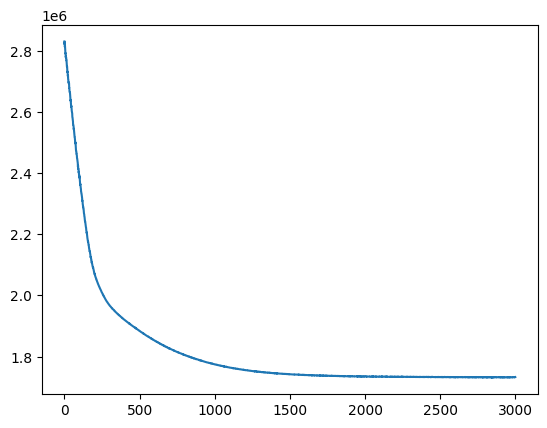

In [34]:
# plot the ELBO across epochs
plt.plot(loss_history)

We extract the factor matrices for each of the dimension. Each factor matrice if of size n_dimension x n_factors, for instance A1, the sample matrix, will be of size n_samples x n_factors. A2 and A3 are the cell type and feature matrices respectively

In [134]:
A2_sample = samples["A2"].detach().cpu()
A1_sample = samples["A1"].detach().cpu()
A3_sample = samples["A3"].detach().cpu()

We create a loadings tensor by combining the cell type and feature factor matrices to get a factor loading of size cell type x features x factors

In [135]:
loadings = torch.einsum('jr,kr->jkr', A2_sample, A3_sample)

## Cell loadings

### RNA Seq

We can look at the cell type x gene loadings for the single cell data

In [144]:
scRNA['Ctype'] = scRNA['Ctype'].str.replace('Mature_B', 'Mature B', regex=False)

We can observe for different factors different clusterings and different gene signatures

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


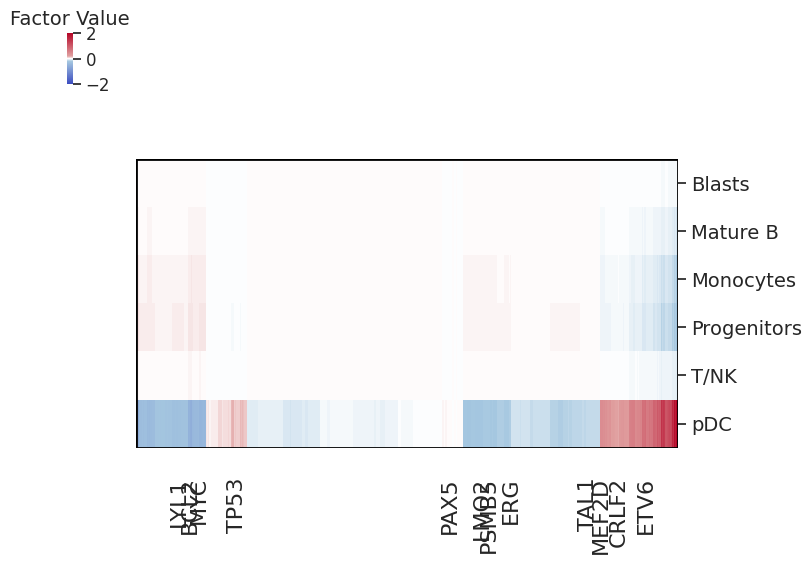

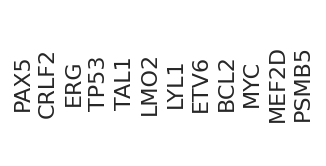

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


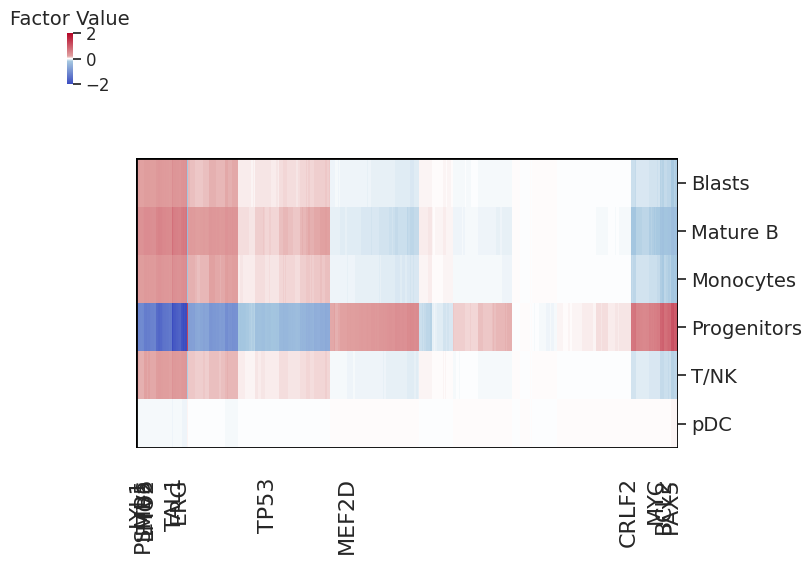

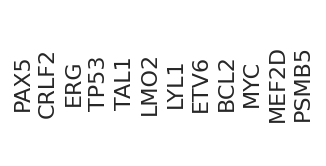

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


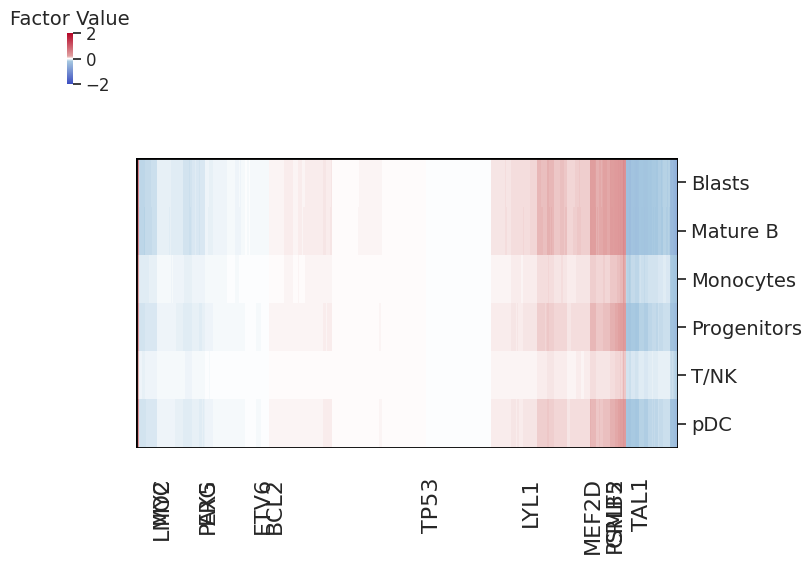

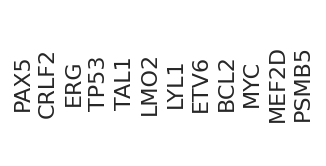

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


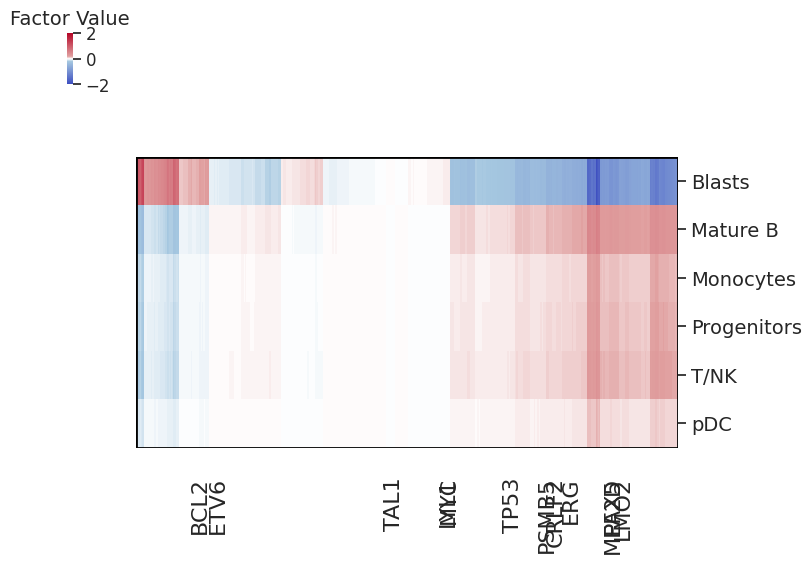

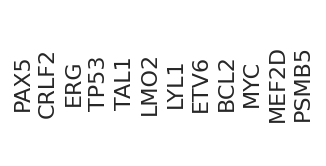

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


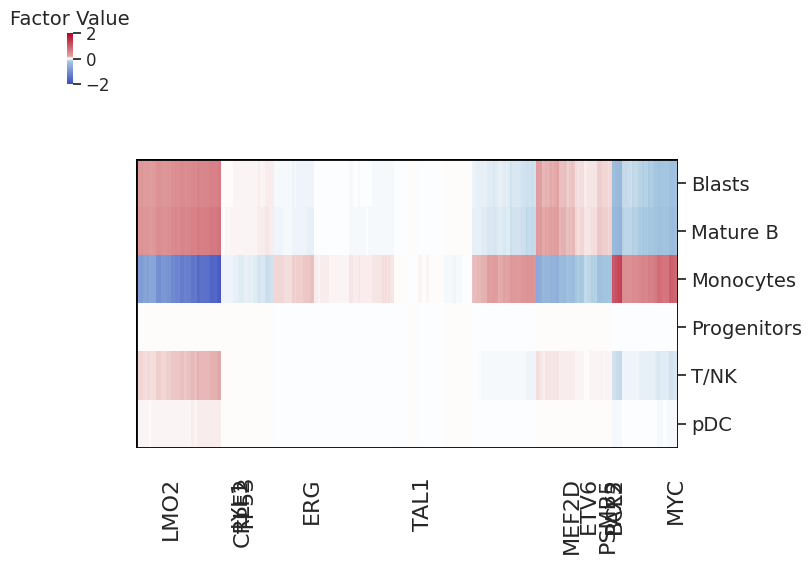

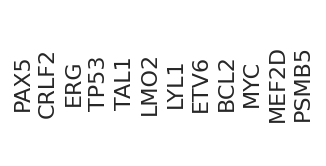

/home/kdeazevedo/opt/anaconda3/envs/parafac/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1028243/921389485.py:111: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


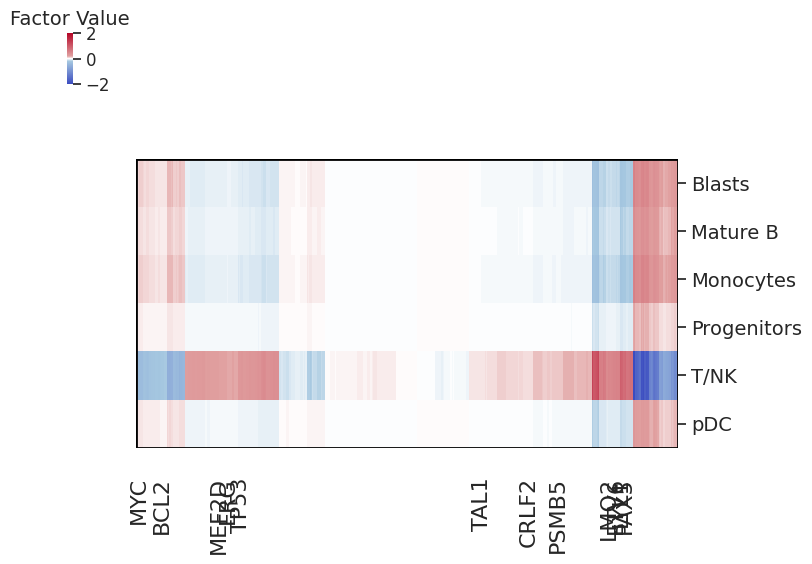

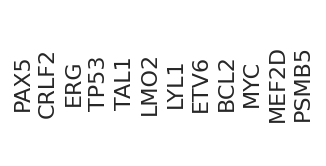

In [145]:
import math
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

n_factors = loadings.shape[2]
n_per_panel = 6  # Number of clustermaps per panel
n_panels = math.ceil(n_factors / n_per_panel)  # Total number of panels
n_cols = 2  # Number of columns per panel
n_rows = math.ceil(n_per_panel / n_cols)  # Automatically calculate rows for 6 clustermaps
genes_of_interest = ['PAX5','CRLF2','ERG', 'NT5C2', 'TP53', 'TAL1', 'TLX1', 'HOXA', 'NKX2-1', 'LMO2', 'LYL1', 'KMT2A', 'DUX4', 'ETV6', 'ZNF384',
                     'IKZF1', 'JAK1', ' JAK2', 'NOTCH1', 'CREBBP', 'BCL2', 'MYC', 'NUTM1', 'MEF2D', ' KMT2A', 'DUX4', 'PSMB5', 'DOT1L']
genes = scRNA.drop(columns=['Condition']).columns.to_list()[1:]


RNA_linkage=[]
# Loop over the factors in panels of 6
for panel in range(n_panels):
    for i in range(n_per_panel):
        factor_idx = panel * n_per_panel + i
        if factor_idx >= n_factors:
            break
        
        # Extract the CellType x Features matrix for the current factor
        data_matrix = loadings[:, :len(scRNA.drop(columns=['Condition']).columns.to_list()[1:]), factor_idx]
        #genes = scRNA.drop(columns=['Condition']).columns.to_list()[1:] + df_merged.columns.to_list()[1:]
        # Convert to DataFrame for better visualization
        df = pd.DataFrame(data_matrix.T, 
                          index=genes, 
                          columns=scRNA['Ctype'].unique())
        list_df.append(df)
        
        # Create and show the clustermap
        #sns.set(font_scale=5)
        # Create the clustermap
        # Set visual style
        sns.set(context="notebook", style="white", font_scale=1.5)
        
        # Create a diverging norm centered at 0 (so 0 is always white)
        div_norm = TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)

        custom_coolwarm = LinearSegmentedColormap.from_list(
            'custom_coolwarm',
            [
                (0.0, '#3B4CC0'),   # deep blue
                (0.45, '#A6C8E0'),  # light blue
                (0.5, '#FFFFFF'),   # white
                (0.55, '#E09F9F'),  # light red
                (1.0, '#B40426'),   # deep red
            ],
            N=256
        )
                
        # Create the clustermap
        g = sns.clustermap(
            df.T,
            cmap=custom_coolwarm,
            norm=div_norm,
            method='average',
            figsize=(8, 6),
            metric='euclidean',
            cbar=True,
            row_cluster=False,
            dendrogram_ratio=(.01, .15),
            cbar_pos=(0.02, 0.8, 0.02, 0.18)  # x, y, width, height
        )
        
        # Remove dendrograms
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        
        # Make colorbar thinner and clean
        if g.cax:
            g.cax.tick_params(labelsize=12)
            g.cax.set_title('Factor Value', fontsize=14)
        
        # Reorder and label genes of interest
        reordered_genes = g.data2d.columns
        filtered_genes = [gene for gene in genes_of_interest if gene in reordered_genes]
        x_positions = [np.where(reordered_genes == gene)[0][0] for gene in filtered_genes]
        
        # Hide default x-ticks
        g.ax_heatmap.set_xticks([])
        g.ax_heatmap.set_xticklabels([])
        
        # Set custom x-ticks for selected genes
        g.ax_heatmap.set_xticks(x_positions)
        g.ax_heatmap.set_xticklabels(filtered_genes)
        
        # Improve x-label visibility with smart placement
        plt.setp(g.ax_heatmap.get_xticklabels(),
                 rotation=90,
                 fontsize=16,
                 ha='right',
                 va='center',
                 rotation_mode='anchor')
        
        # Add padding between tick labels and heatmap
        g.ax_heatmap.tick_params(axis='x', pad=15)
        
        # Optional: format y-axis as well
        g.ax_heatmap.tick_params(axis='y', labelsize=14)
        
        # Add border around heatmap
        xmin, xmax = g.ax_heatmap.get_xlim()
        ymin, ymax = g.ax_heatmap.get_ylim()
        border = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=2, edgecolor='black', facecolor='none')
        g.ax_heatmap.add_patch(border)
        
        # Final layout tweaks
        g.fig.tight_layout()
        g.fig.subplots_adjust(bottom=0.2)  # Provide room, now respected due to correct label settings
        
        # Save linkage matrix if needed
        col_linkage = g.dendrogram_col.linkage
        RNA_linkage.append(col_linkage)
        
        plt.show()

        fig, ax = plt.subplots(figsize=(len(filtered_genes) * 0.3, 2))  # Width scales with number of genes
        
        # Plot empty space, only for text labels
        ax.set_xlim(0, len(filtered_genes))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Hide axes
        
        # Add each gene name, rotated 90°
        for i, gene in enumerate(filtered_genes):
            ax.text(i + 0.5, 0.5, gene,
                    rotation=90,
                    fontsize=16,
                    ha='center',
                    va='center')
        
        fig.patch.set_facecolor('white')  # Ensure white background
        plt.tight_layout()
        plt.show()

We can extract the top genes of each factors and proceed to pathway analysis to identify gene modules associated with a particular factor. Here for instance, for factor 0, we extract the top 500 genes for each cell type.

In [172]:
top_genes_factor5_Blasts = list_df[0].nlargest(500, 'Blasts')
top_genes_factor5_Monocytes = list_df[0].nlargest(500, 'Monocytes')
top_genes_factor5_Progenitors = list_df[0].nlargest(500, 'Progenitors')
top_genes_factor5_pDC = list_df[0].nlargest(500, 'pDC')
top_genes_factor5_Mature_B = list_df[0].nlargest(500, 'Mature B')
top_genes_factor5_T = list_df[0].nlargest(500, 'T/NK')

In [173]:
import gseapy as gp

enrich_dfs = []
for top_genes_factor in [top_genes_factor5_Blasts, top_genes_factor5_Monocytes, top_genes_factor5_Progenitors, top_genes_factor5_Mature_B,
                        top_genes_factor5_T, top_genes_factor5_pDC]:
    #ORA
    enrich_results = gp.enrichr(
        gene_list=top_genes_factor.index.to_list(),
        gene_sets=["GO_Molecular_Function_2025", "MSigDB_Hallmark_2020", "MSigDB_Oncogenic_Signatures", "KEGG_2021_Human"],  # Use KEGG, GO, Reactome, etc.
        organism="Human",  # Change if needed
        outdir=None,  # No output files
    )

    enrich_df = enrich_results.results[['Term', 'P-value', 'Adjusted P-value', 'Overlap', 'Odds Ratio']]
    enrich_df_all = enrich_df
    enrich_df = enrich_df[enrich_df['Adjusted P-value'] < 0.05]
    enrich_dfs.append(enrich_df[['Term', 'Adjusted P-value', 'Overlap', 'Odds Ratio']])



In [174]:
# Start with the first dataframe, rename columns
merged_df = enrich_dfs[0].rename(columns={'Adjusted P-value': '0 Adjusted P-value', 
                                          'Overlap': '0 Overlap', 
                                          'Odds Ratio': '0 OR'}).set_index('Term')

# Iterate over the remaining dataframes and merge them
for i, df in enumerate(enrich_dfs[1:], start=1):
    df = df.rename(columns={'Adjusted P-value': '{} Adjusted P-value'.format(str(i)),
                           'Overlap': '{} Overlap'.format(str(i)),
                           'Odds Ratio': '{} OR'.format(str(i)),}).set_index('Term')
    merged_df = merged_df.join(df, how='outer')

# Convert to float and fill missing values with NaN
#merged_df = merged_df.astype(float)

In [183]:
merged_df.index.unique()

Index(['Acute myeloid leukemia', 'Adipogenesis', 'Allograft Rejection',
       'Apoptosis', 'B cell receptor signaling pathway', 'CAMP UP.V1 DN',
       'CAMP UP.V1 UP', 'CSR LATE UP.V1 DN', 'CSR LATE UP.V1 UP',
       'CYCLIN D1 KE .V1 DN', 'CYCLIN D1 UP.V1 DN',
       'Cadherin Binding (GO:0045296)', 'Cholesterol Homeostasis',
       'Complement', 'E2F Targets', 'E2F1 UP.V1 DN', 'EGFR UP.V1 DN',
       'EGFR UP.V1 UP', 'ERB2 UP.V1 DN', 'ESC J1 UP EARLY.V1 DN',
       'ESC J1 UP LATE.V1 DN', 'ESC V6.5 UP EARLY.V1 DN',
       'ESC V6.5 UP LATE.V1 UP', 'Epstein-Barr virus infection',
       'Estrogen Response Early', 'G2-M Checkpoint', 'HOXA9 DN.V1 DN',
       'HOXA9 DN.V1 UP', 'Hematopoietic cell lineage', 'Hypoxia',
       'IL-2/STAT5 Signaling', 'IL-6/JAK/STAT3 Signaling', 'IL2 UP.V1 UP',
       'Inflammatory Response', 'Inflammatory bowel disease',
       'Interferon Alpha Response', 'Interferon Gamma Response',
       'LTE2 UP.V1 DN', 'Legionellosis', 'Leishmaniasis',
       'Lipid

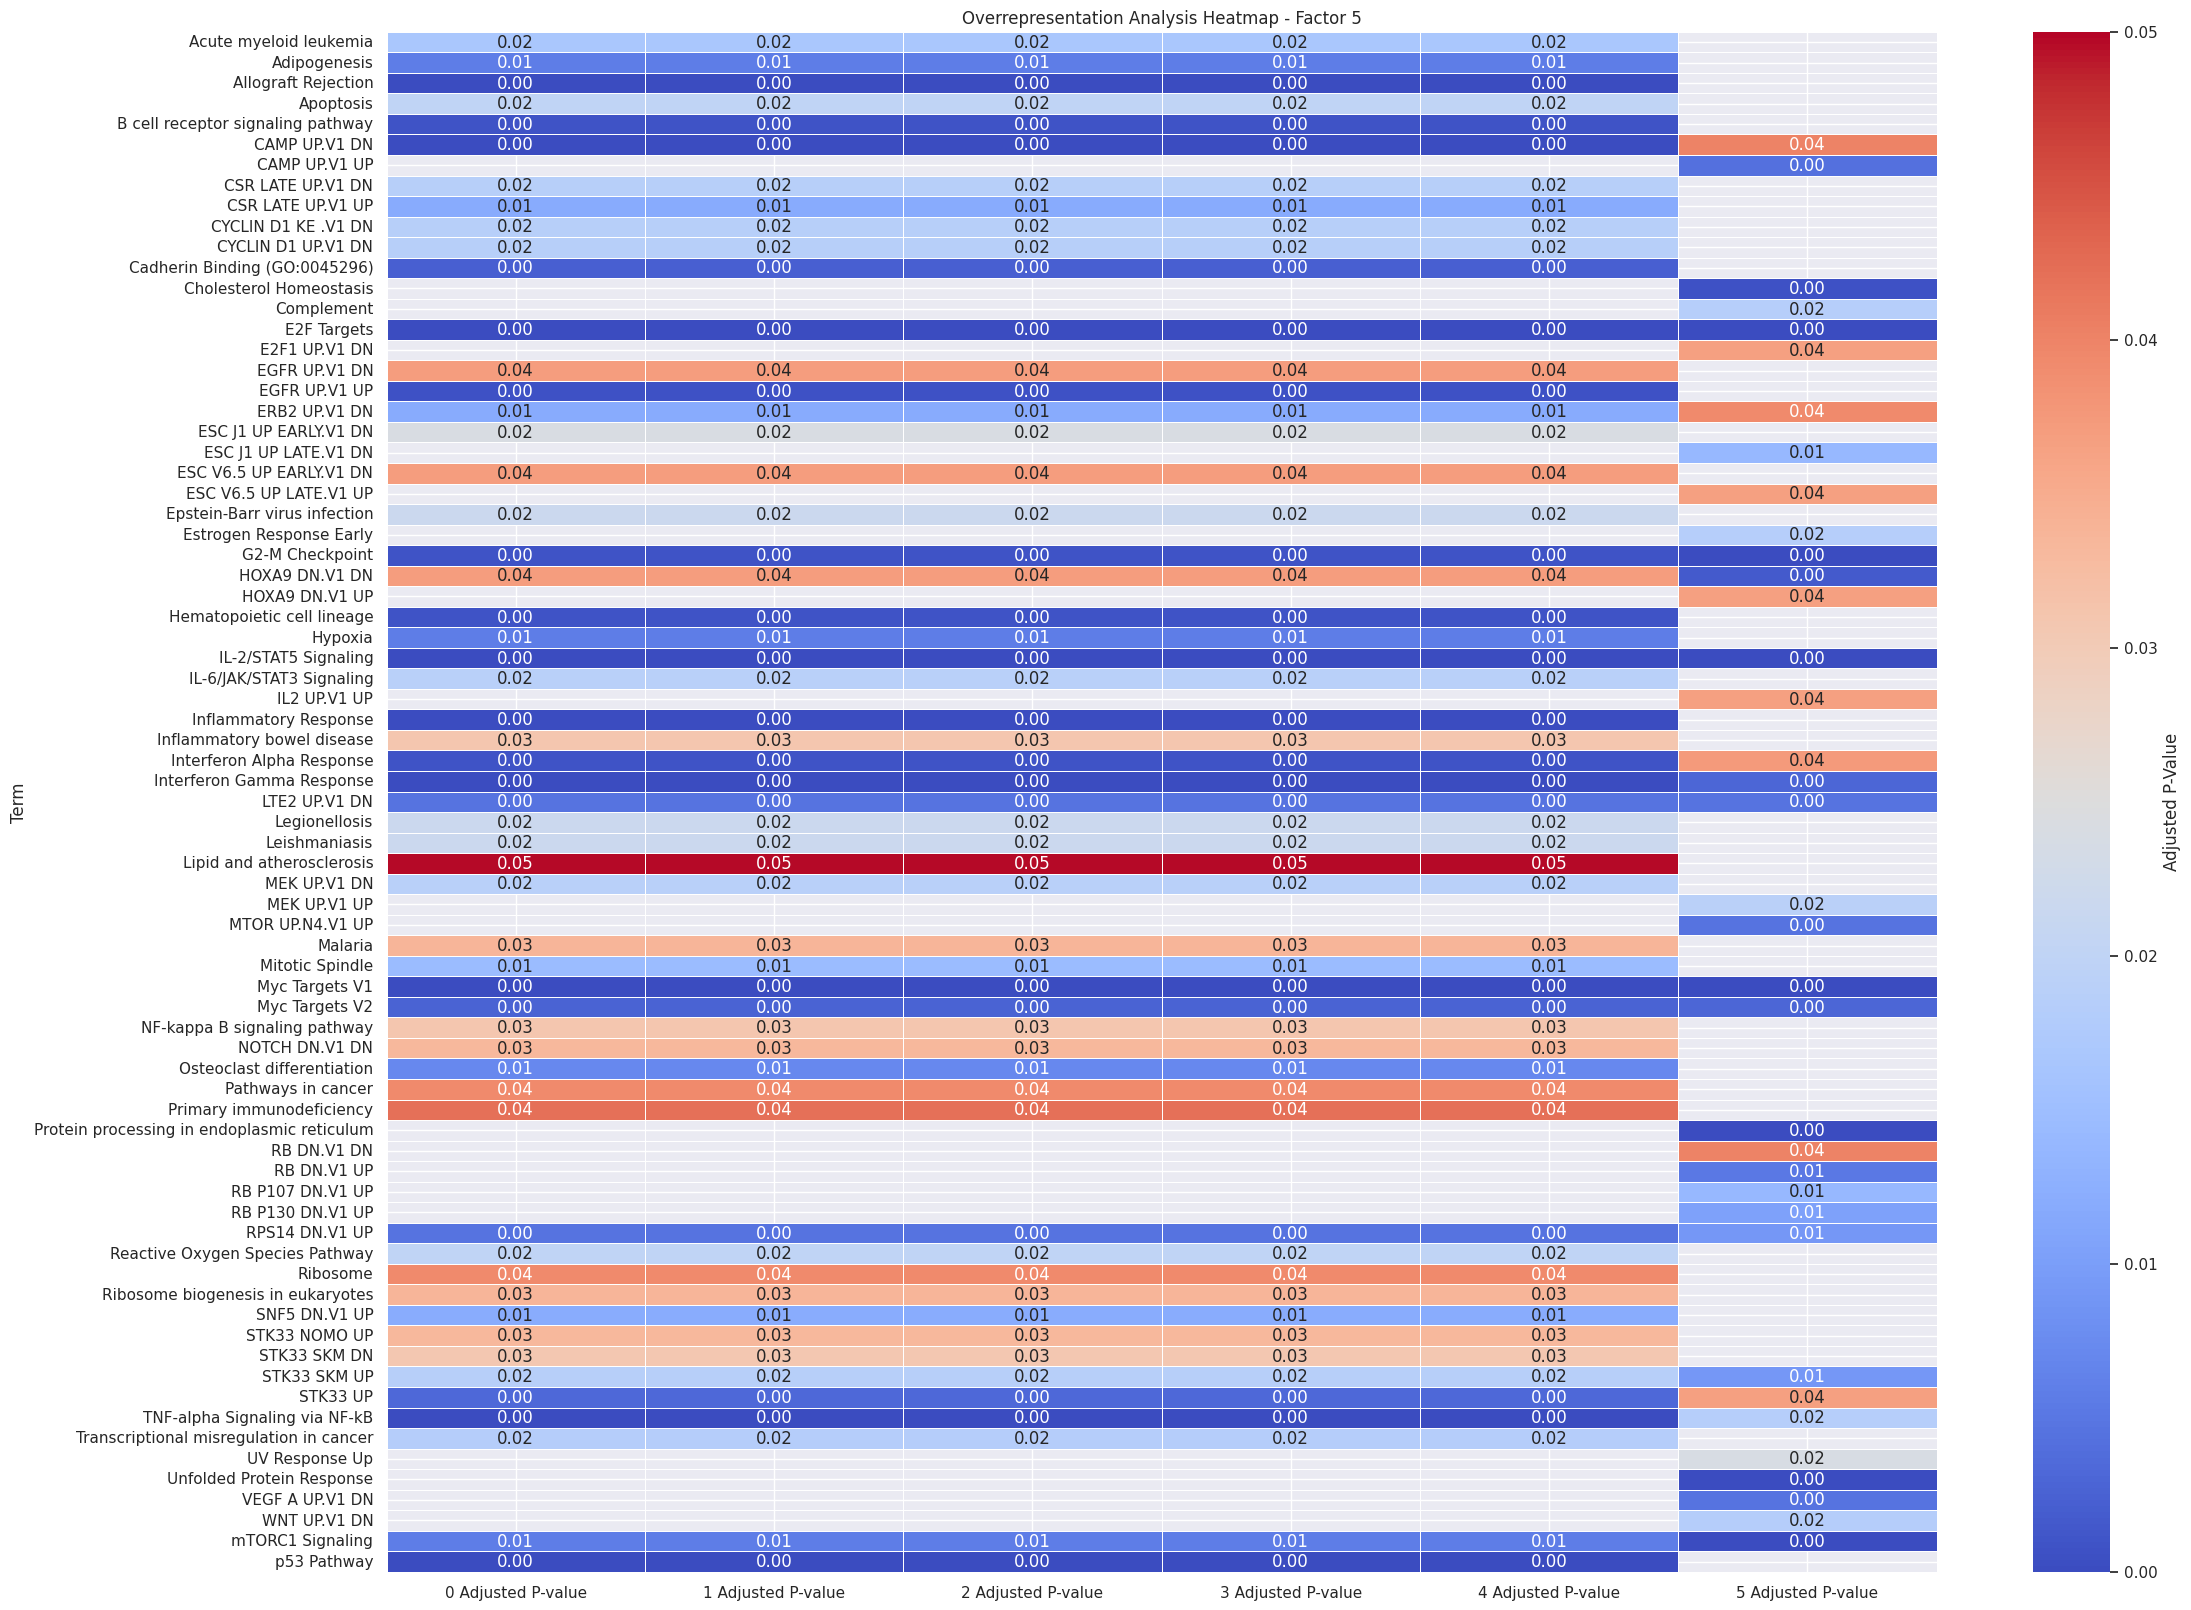

In [176]:
plt.figure(figsize=(25, 20))
sns.heatmap(merged_df.iloc[:, [0, 3, 6, 9, 12, 15]], cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, 
            cbar_kws={'label': 'Adjusted P-Value'}, 
            mask=merged_df.iloc[:, [0, 3, 6, 9, 12, 15]].isna(),  # Gray squares where values are missing
            vmin=0, vmax=0.05)

sns.set(font_scale=1)

plt.title("Overrepresentation Analysis Heatmap - Factor 5")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import Normalize


# PARAMETERS
selected_pathways = ["p53 Pathway", 
                     "Estrogen Response Early", 
                     "Protein processing in endoplasmic reticulum", 
                     "mTORC1 Signaling",
                     "IL-6/JAK/STAT3 Signaling",
                     "Unfolded Protein Response",
                     "Mitotic Spindle",
                     "UV Response Up",
                     "Hypoxia",
                     "Primary immunodeficiency"]

pval_threshold = 0.05

# Extract pathway rows of interest
filtered_df = merged_df.loc[selected_pathways]

# Reshape data to long format
long_data = []
n_cell_types = len([col for col in merged_df.columns if "Adjusted P-value" in col])

for cell_type_idx in range(n_cell_types):
    for pathway in selected_pathways:
        try:
            pval = filtered_df.loc[pathway, f"{cell_type_idx} Adjusted P-value"]
            overlap = filtered_df.loc[pathway, f"{cell_type_idx} Overlap"]
            or_value = filtered_df.loc[pathway, f"{cell_type_idx} OR"]
        except KeyError:
            continue

        if pd.notna(pval):
            if isinstance(overlap, str) and '/' in overlap:
                p_genes = round((float(overlap.split('/')[0])/float(overlap.split('/')[1]))*100, 2)
            else:
                p_genes = np.nan

            long_data.append({
                "Pathway": pathway,
                "Cell Type": f"Cell Type {cell_type_idx}",
                "Adjusted P-value": pval,
                "OR": or_value,
                "Gene Percent": p_genes
            })

dotplot_df = pd.DataFrame(long_data)
dotplot_df = dotplot_df[dotplot_df["Adjusted P-value"] <= pval_threshold]

# PLOT
# Set up plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 7))

# Plot
scatter = sns.scatterplot(
    data=dotplot_df,
    x="Pathway", y="Cell Type",
    hue="OR",
    size="Gene Percent",
    sizes=(50, 300),
    palette="viridis",
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    legend=False
)

# Flip axes if needed to match image style
#ax.invert_yaxis()


# Labels & ticks
ax.set_xlabel("Gene_set", fontsize=14)
ax.set_ylabel("", fontsize=14)
ax.set_title("KEGG", fontsize=18, weight="bold")
plt.xticks(rotation=45, ha="right")

# Colorbar
norm = Normalize(dotplot_df["OR"].min(), dotplot_df["OR"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("OR", fontsize=12)

# Custom size legend (Gene Percent)
legend_sizes = [10, 15, 20]
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'{s}%', 
           markerfacecolor='gray', markersize=np.sqrt(s * 3), 
           markeredgecolor="black", lw=0.5)
    for s in legend_sizes
]

# Position the custom size legend just below the colorbar
# cbar.ax.get_position() gives us [x0, y0, width, height]
cbbox = cbar.ax.get_position()
legend_ax = fig.add_axes([cbbox.x0, cbbox.y0 - 0.12, cbbox.width, 0.1])
legend_ax.axis("off")

legend = legend_ax.legend(
    handles=legend_handles,
    title="% Genes\nin set",
    loc="center",
    frameon=False,
    ncol=1,
    fontsize=10,
    title_fontsize=11
)

# Adjust layout to prevent overlapping
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1028243/1246643705.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


### Metadata

We can explore the sample latent representation given by MUSIC and confront it with metadata

In [81]:
metadata_scRNA_unique_samples = metadata_scRNA_merged.drop_duplicates(subset="sample", keep="first").reset_index(drop=True)

In [82]:
samples_factor = pd.DataFrame(A1_sample).set_index(scRNA.index.unique())
samples_factor = samples_factor.add_prefix('Factor')
samples_factor['Condition'] = np.where(samples_factor.index.isin(['HumanHealthy_2117', 'HumanHealthy_2471', 'donor2111', 'donor2153', 'donor2689']), 
                           'Healthy', 'ALL')

cell_factor = pd.DataFrame(A2_sample).set_index(scRNA['Ctype'].unique())
cell_factor = cell_factor.add_prefix('Factor')

In [83]:
samples_factor['Condition'] = samples_factor['Condition'].astype(str)

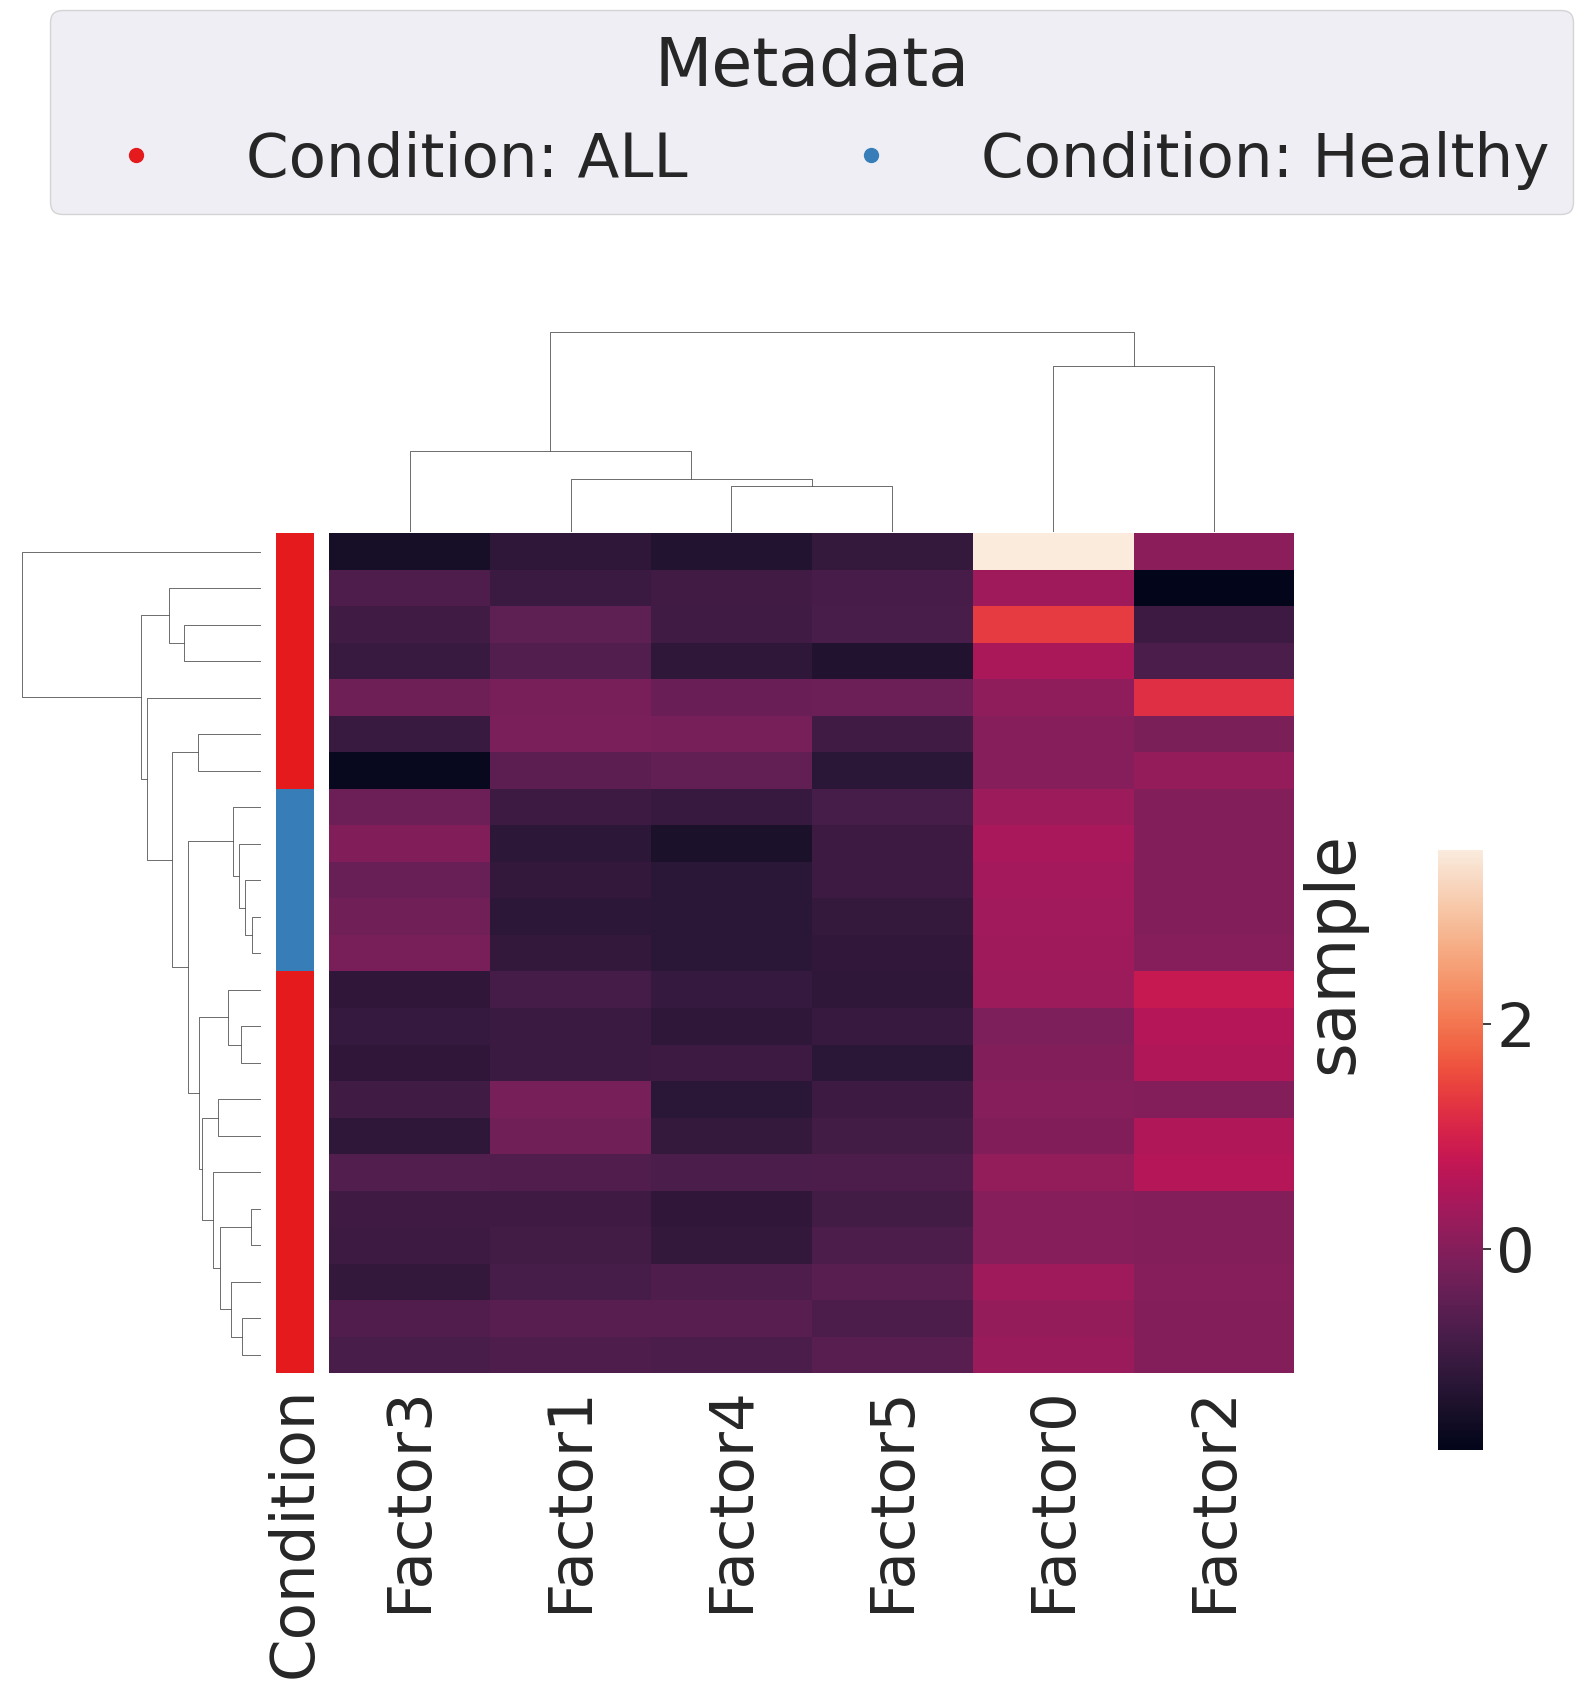

In [84]:
# Automatically map colors based on unique values in metadata
unique_conditions = samples_factor['Condition'].unique()
conditions_palette = sns.color_palette("Set1", len(unique_conditions))
# Create a dictionary mapping each unique value to a color
condition_colors = dict(zip(unique_conditions, conditions_palette))
# Create a DataFrame of colors for col_colors
row_colors = samples_factor.Condition.map(condition_colors)
sns.set(font_scale=4)
hm = sns.clustermap(data=samples_factor.drop(['Condition'], axis=1),  
                    figsize=(15, 15), metric='euclidean',
                    row_colors=row_colors, yticklabels=False)
hm.ax_cbar.set_position((1, .2, .03, .4))
#hm.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
#hm.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
 # Create the Treatment legend handles
handles = [plt.Line2D([0], [0], marker='o', color=condition_colors[label], linestyle='', markersize=10) for label in unique_conditions]
labels= [f'Condition: {label}' for label in unique_conditions]
# Display the combined legend
hm.ax_col_dendrogram.legend(handles, labels, title='Metadata', loc='center', bbox_to_anchor=(0.5, 2), ncol=2)

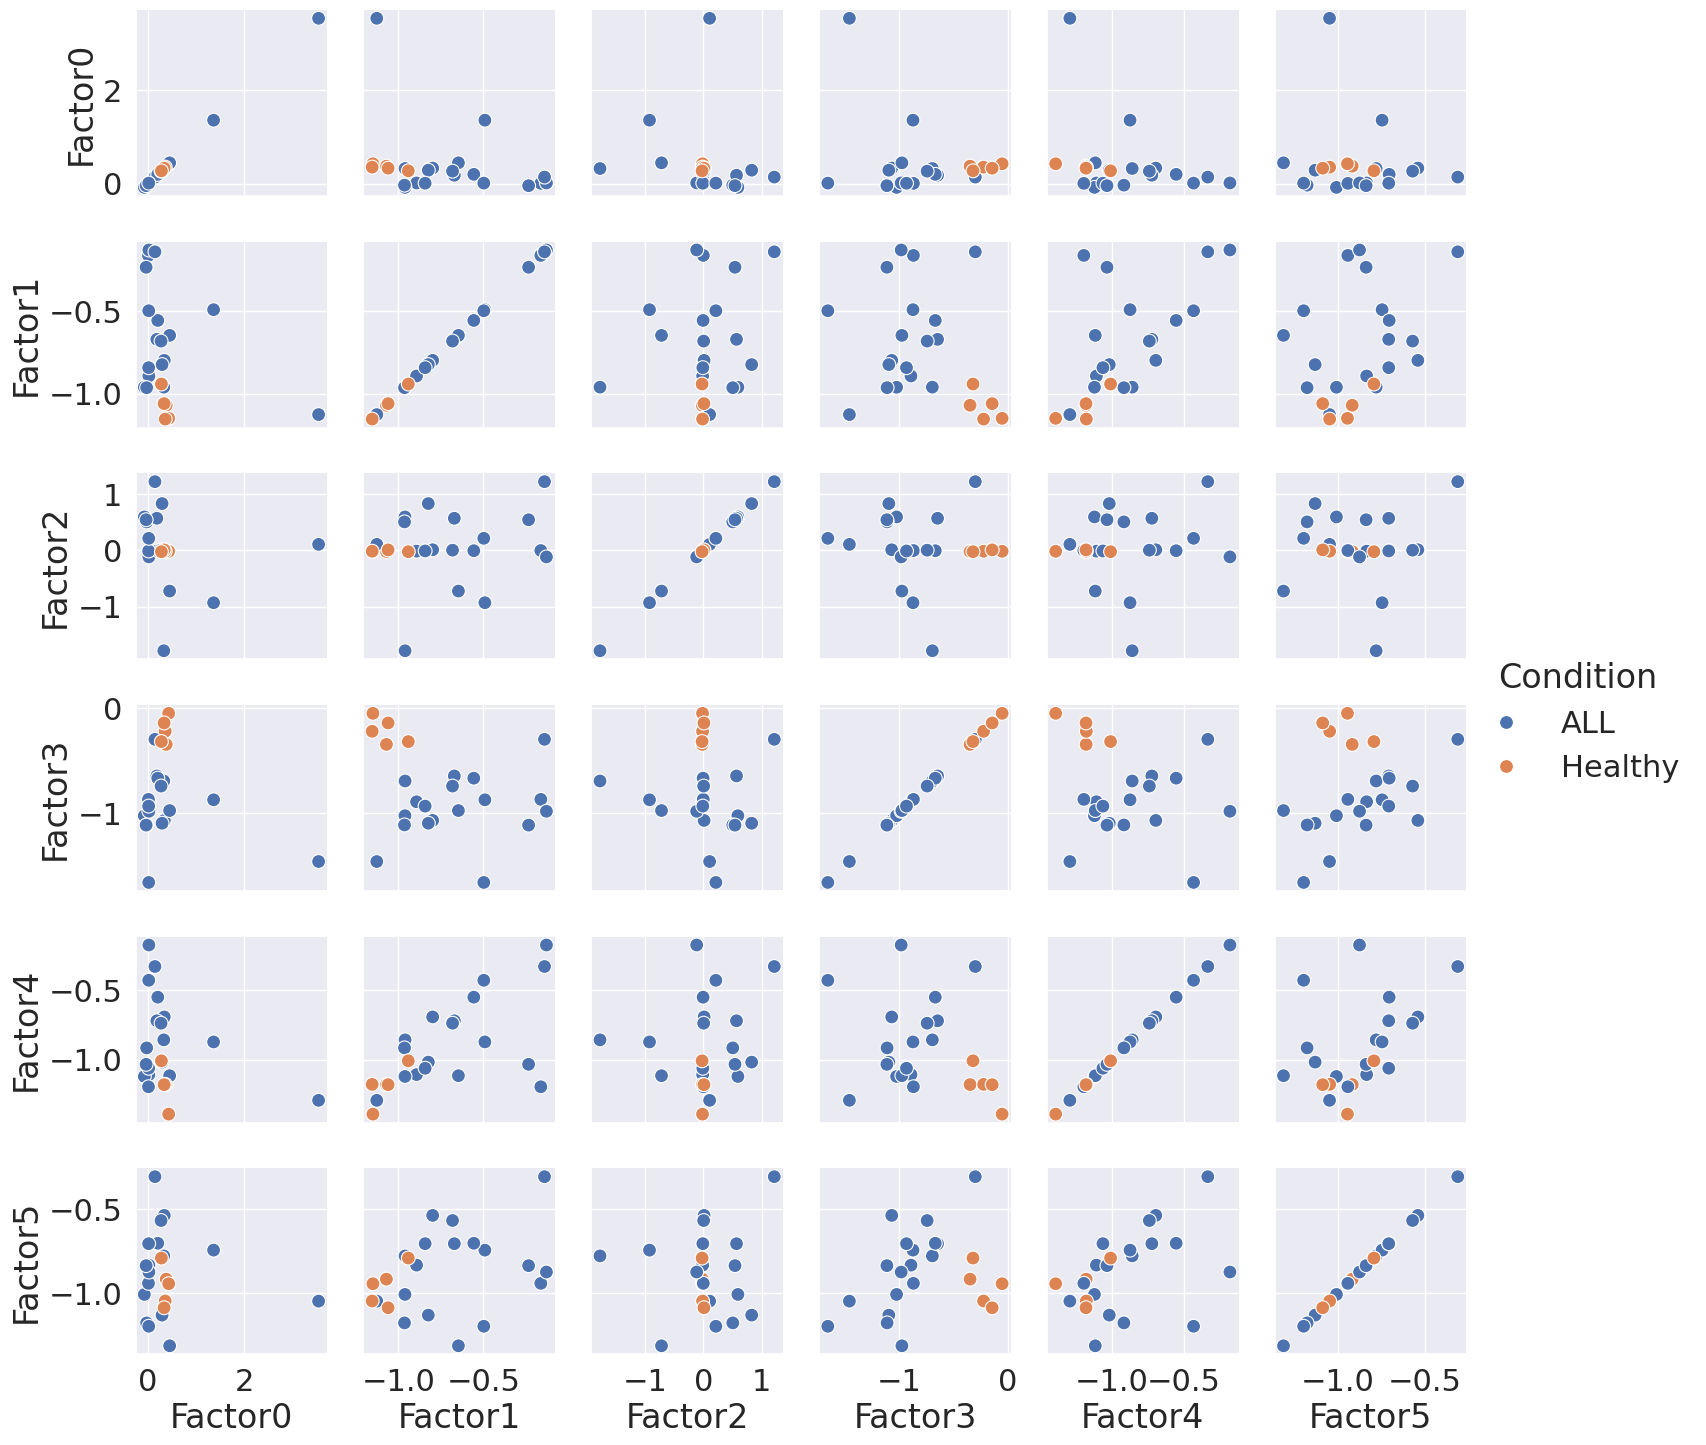

In [85]:
sns.set_theme(rc={'figure.figsize':(30,30)})
sns.set(font_scale=2)
g = sns.PairGrid(samples_factor.reset_index(), vars=list(samples_factor.columns[0:6]), hue = 'Condition')
g.map(sns.scatterplot, s=100)
g.add_legend()

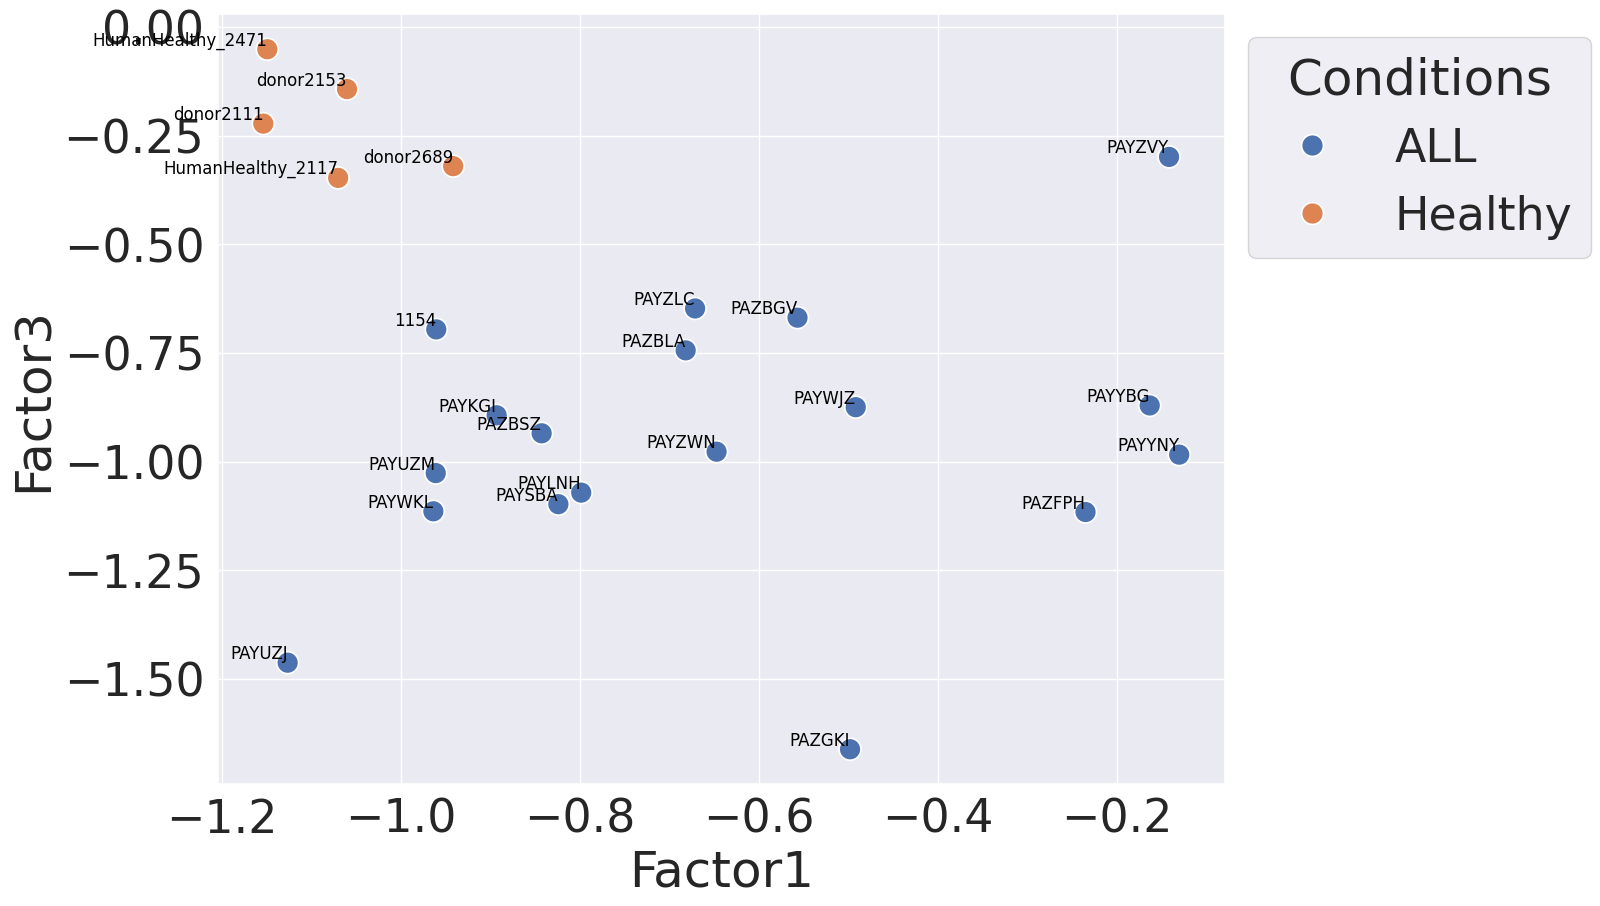

In [88]:
# Set the theme and font scale
sns.set_theme(rc={'figure.figsize':(13,10)})
sns.set(font_scale=3)

# Create the scatterplot
ax = sns.scatterplot(samples_factor.reset_index(), x='Factor1', y='Factor3', hue='Condition', s=250)

# Add sample labels to the points
for i in range(samples_factor.shape[0]):
    ax.text(samples_factor.iloc[i]['Factor1'], samples_factor.iloc[i]['Factor3'], 
            str(samples_factor.index[i]), fontsize=12, color='black', ha='right', va='bottom')

# Create a legend positioned to the right
plt.legend(title='Conditions', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

In [89]:
merged_df = samples_factor.merge(metadata_scRNA_unique_samples, left_index=True, right_on="sample")

In [91]:
samples_factor['Age'] = merged_df['Age'].to_list()

In [92]:
samples_factor['PresumedFusion'] = merged_df['PresumedFusion'].to_list()

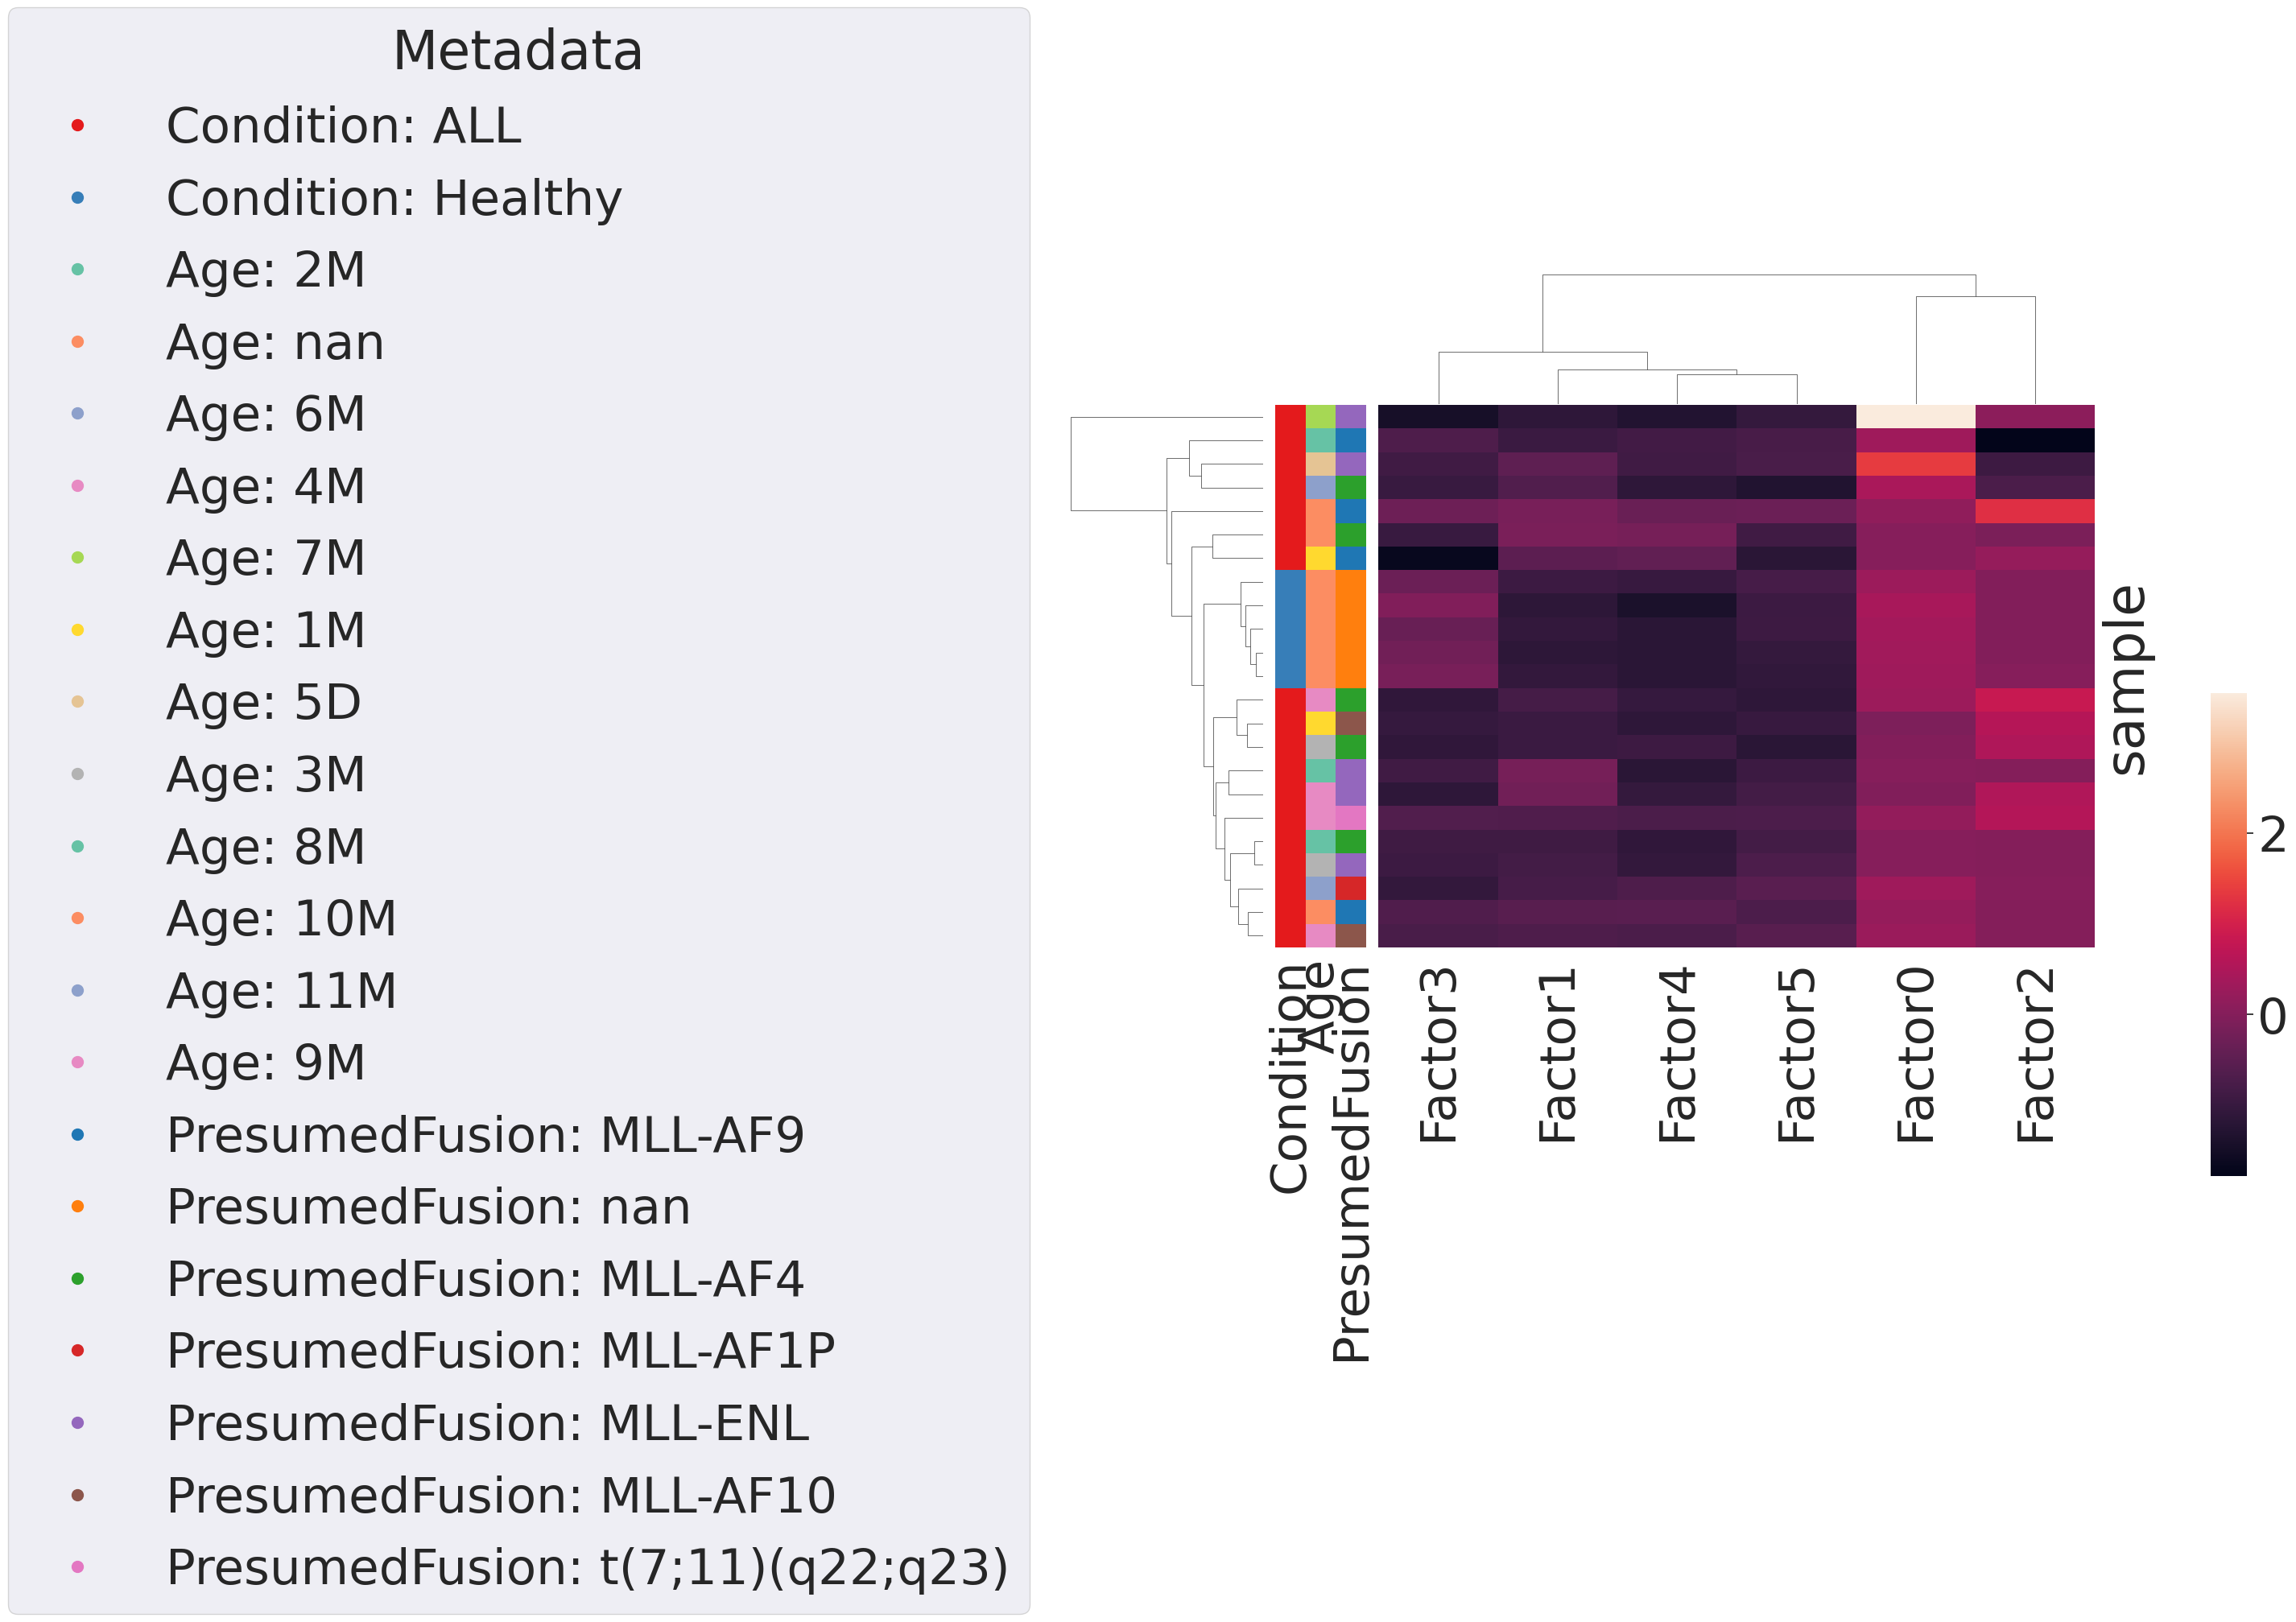

In [94]:
# Automatically map colors based on unique values in metadata
unique_conditions = samples_factor['Condition'].unique()
conditions_palette = sns.color_palette("Set1", len(unique_conditions))
# Create a dictionary mapping each unique value to a color
condition_colors = dict(zip(unique_conditions, conditions_palette))
# Create a DataFrame of colors for col_colors

# Automatically map colors based on unique values in metadata
unique_age = samples_factor['Age'].unique()
age_palette = sns.color_palette("Set2", len(unique_age))
# Create a dictionary mapping each unique value to a color
age_colors = dict(zip(unique_age, age_palette))
# Create a DataFrame of colors for col_colors

# Automatically map colors based on unique values in metadata
unique_fusions = samples_factor['PresumedFusion'].unique()
fusions_palette = sns.color_palette("tab10", len(unique_fusions))
# Create a dictionary mapping each unique value to a color
fusions_colors = dict(zip(unique_fusions, fusions_palette))
# Create a DataFrame of colors for col_colors

row_colors = pd.DataFrame({
    'Condition': samples_factor['Condition'].map(condition_colors),
    'Age': samples_factor['Age'].map(age_colors),
    'PresumedFusion': samples_factor['PresumedFusion'].map(fusions_colors)
}, index=samples_factor.index)
        
sns.set(font_scale=4)
hm = sns.clustermap(data=samples_factor.drop(['Age', 'Condition', 'PresumedFusion'], axis=1),  
                    figsize=(15, 15), metric='euclidean',
                    row_colors=row_colors, yticklabels=False)
hm.ax_cbar.set_position((1, .2, .03, .4))
#hm.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
#hm.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
 # Create the Treatment legend handles
handles_condition = [plt.Line2D([0], [0], marker='o', color=condition_colors[label], linestyle='', markersize=10) for label in unique_conditions]
labels_condition= [f'Condition: {label}' for label in unique_conditions]
handles_age = [plt.Line2D([0], [0], marker='o', color=age_colors[label], linestyle='', markersize=10) for label in unique_age]
labels_age= [f'Age: {label}' for label in unique_age]
handles_fusion = [plt.Line2D([0], [0], marker='o', color=fusions_colors[label], linestyle='', markersize=10) for label in unique_fusions]
labels_fusion= [f'PresumedFusion: {label}' for label in unique_fusions]
# Combine handles and labels for both Condition and Treatment
handles = handles_condition + handles_age + handles_fusion
labels = labels_condition + labels_age + labels_fusion
# Display the combined legend
hm.ax_col_dendrogram.legend(handles, labels, title='Metadata', loc='center', bbox_to_anchor=(-1.2, -3), ncol=1)

An interesting fact we can see in the last heatmap for instance is a subgroup of patient by isolated by Factor 0. We can put that in contrast with the 